# Figures in paper

Håkon Wiik Ånes (hakon.w.anes@ntnu.no)

Figures are generated from combined data from three datasets from each of the
following conditions:

* As deformed (0s)
* Annealed to 175 $^{\circ}$C (175c)
* Annealed to 300 $^{\circ}$C (300c)
* Annealed to 325 $^{\circ}$C (325c)

Import required libraries and print their versions

In [1]:
# Switch to interactive Matplotlib backend (e.g. qt5) for control point determination
%matplotlib inline

from datetime import date
import importlib_metadata
import os
import warnings

import matplotlib.colors as mcolors
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import host_subplot, make_axes_locatable
import numpy as np
import pandas as pd
import pyexcel_ods3 as pxl
import scipy.stats as scs

from mapregions import MapRegions


print("Run date: ", date.today())
print("\nSoftware versions\n-----------------")
for pkg in ["mapregions", "matplotlib", "numpy", "pandas", "pyexcel_ods3", "scipy"]:
    if pkg == "numpy":
        ver = np.__version__
    else:
        ver = importlib_metadata.version(pkg)
    print(pkg, ":", ver)

Run date:  2022-10-14

Software versions
-----------------
mapregions : 0.1.dev1
matplotlib : 3.6.0
numpy : 1.23.3
pandas : 1.5.0
pyexcel_ods3 : 0.6.1
scipy : 1.9.0


Descriptions of texture components

In [2]:
comp_names = ["Random", "Br", "Cu", "S", "Cube", "CubeND", "P", "Goss", "Cu, S, Br"]
comp_names_low = list(map(str.lower, comp_names))
comp_markers = dict(zip(comp_names, ["o", "d", "^", "*", "s", "s", ">", "o", "d"]))
comp_colors = dict(zip(comp_names, [(1, 1, 1), (1, 0, 1), (0, 0, 1), (0, 0.5, 0), (1, 0, 0), (1, 0.55, 0), (0, 1, 1), (1, 1, 0), mcolors.to_rgb("C2")]))
n_ideal = len(comp_names) - 1
ideal_id = np.arange(n_ideal)

In [7]:
# Directories for input and output
dir_data = "/home/hakon/phd/data/p"
dir_article = "/home/hakon/phd/artikler_abstract/202204_aanes_p_texture_almn_alloy_actamat/latex/fig"

# Matplotlib configuration and keyword arguments
plt.rcParams.update({"font.size": 11, "figure.dpi": 300})
savefig_kw = dict(bbox_inches="tight", pad_inches=0.01, transparent=True)
scatter_kw = dict(s=70, linewidth=2, facecolor="none", clip_on=False)
title_kw = dict(ha="left", va="bottom", fontweight="bold")
bse_ebsd_kw = dict(color="k", linestyle="-", zorder=0, lw=2)

# Nominal step sizes nm/px
step_size = dict(ebsd=100, bse=1 / 39e-3)

# Particle size thresholds
dispersoid_threshold_max = 0.24  # um
dispersoid_threshold_min = 0.03  # um
constituent_threshold = 0.8  # um

# Variables for plotting
titles = ["As def.", r"175 $^{\circ}$C", r"300 $^{\circ}$C", r"325 $^{\circ}$C"]
identifier = ["0s", "175c", "300c", "325c"]

## Recrystallization kinetics and overall texture

### Electrical conductivity, hardness and macrotexture volume fractions

Read data from LibreOffice Calc

In [4]:
def get_data_frame(data):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", np.VisibleDeprecationWarning)
        data_array = np.full(shape=np.shape(data) + np.shape(data[0]), fill_value=np.nan, dtype=object)
    columns = []
    skip = 0
    for i, l in enumerate(data):
        if len(l) == 0:
            skip += 1
        else:
            for j, value in enumerate(l):
                try:
                    if value != "":
                        data_array[i, j] = value
                except IndexError:
                    pass
    return pd.DataFrame(data=data_array[1:-skip], columns=data_array[0])


# EC
data_file = os.path.join(dir_data, "ec/ec.ods")
data = pxl.get_data(data_file)
ec = get_data_frame(data["all"][:-2])[:-1]

# HV
data_file = os.path.join(dir_data, "hv/hv.ods")
data = pxl.get_data(data_file)
hv = get_data_frame(data["ark1"][:-2])[:-1]

# Macrotexture
data_file = os.path.join(dir_data, "macrotexture/macrotexture_3xxx.ods")
data = pxl.get_data(data_file)
texture = get_data_frame(data["Ark1"])

# Exclude as cast and homogenized
ec = ec.iloc[2:]
hv = hv.iloc[2:]
ec = ec.reset_index(drop=True)
hv = hv.reset_index(drop=True)

Plot change in HV and EC

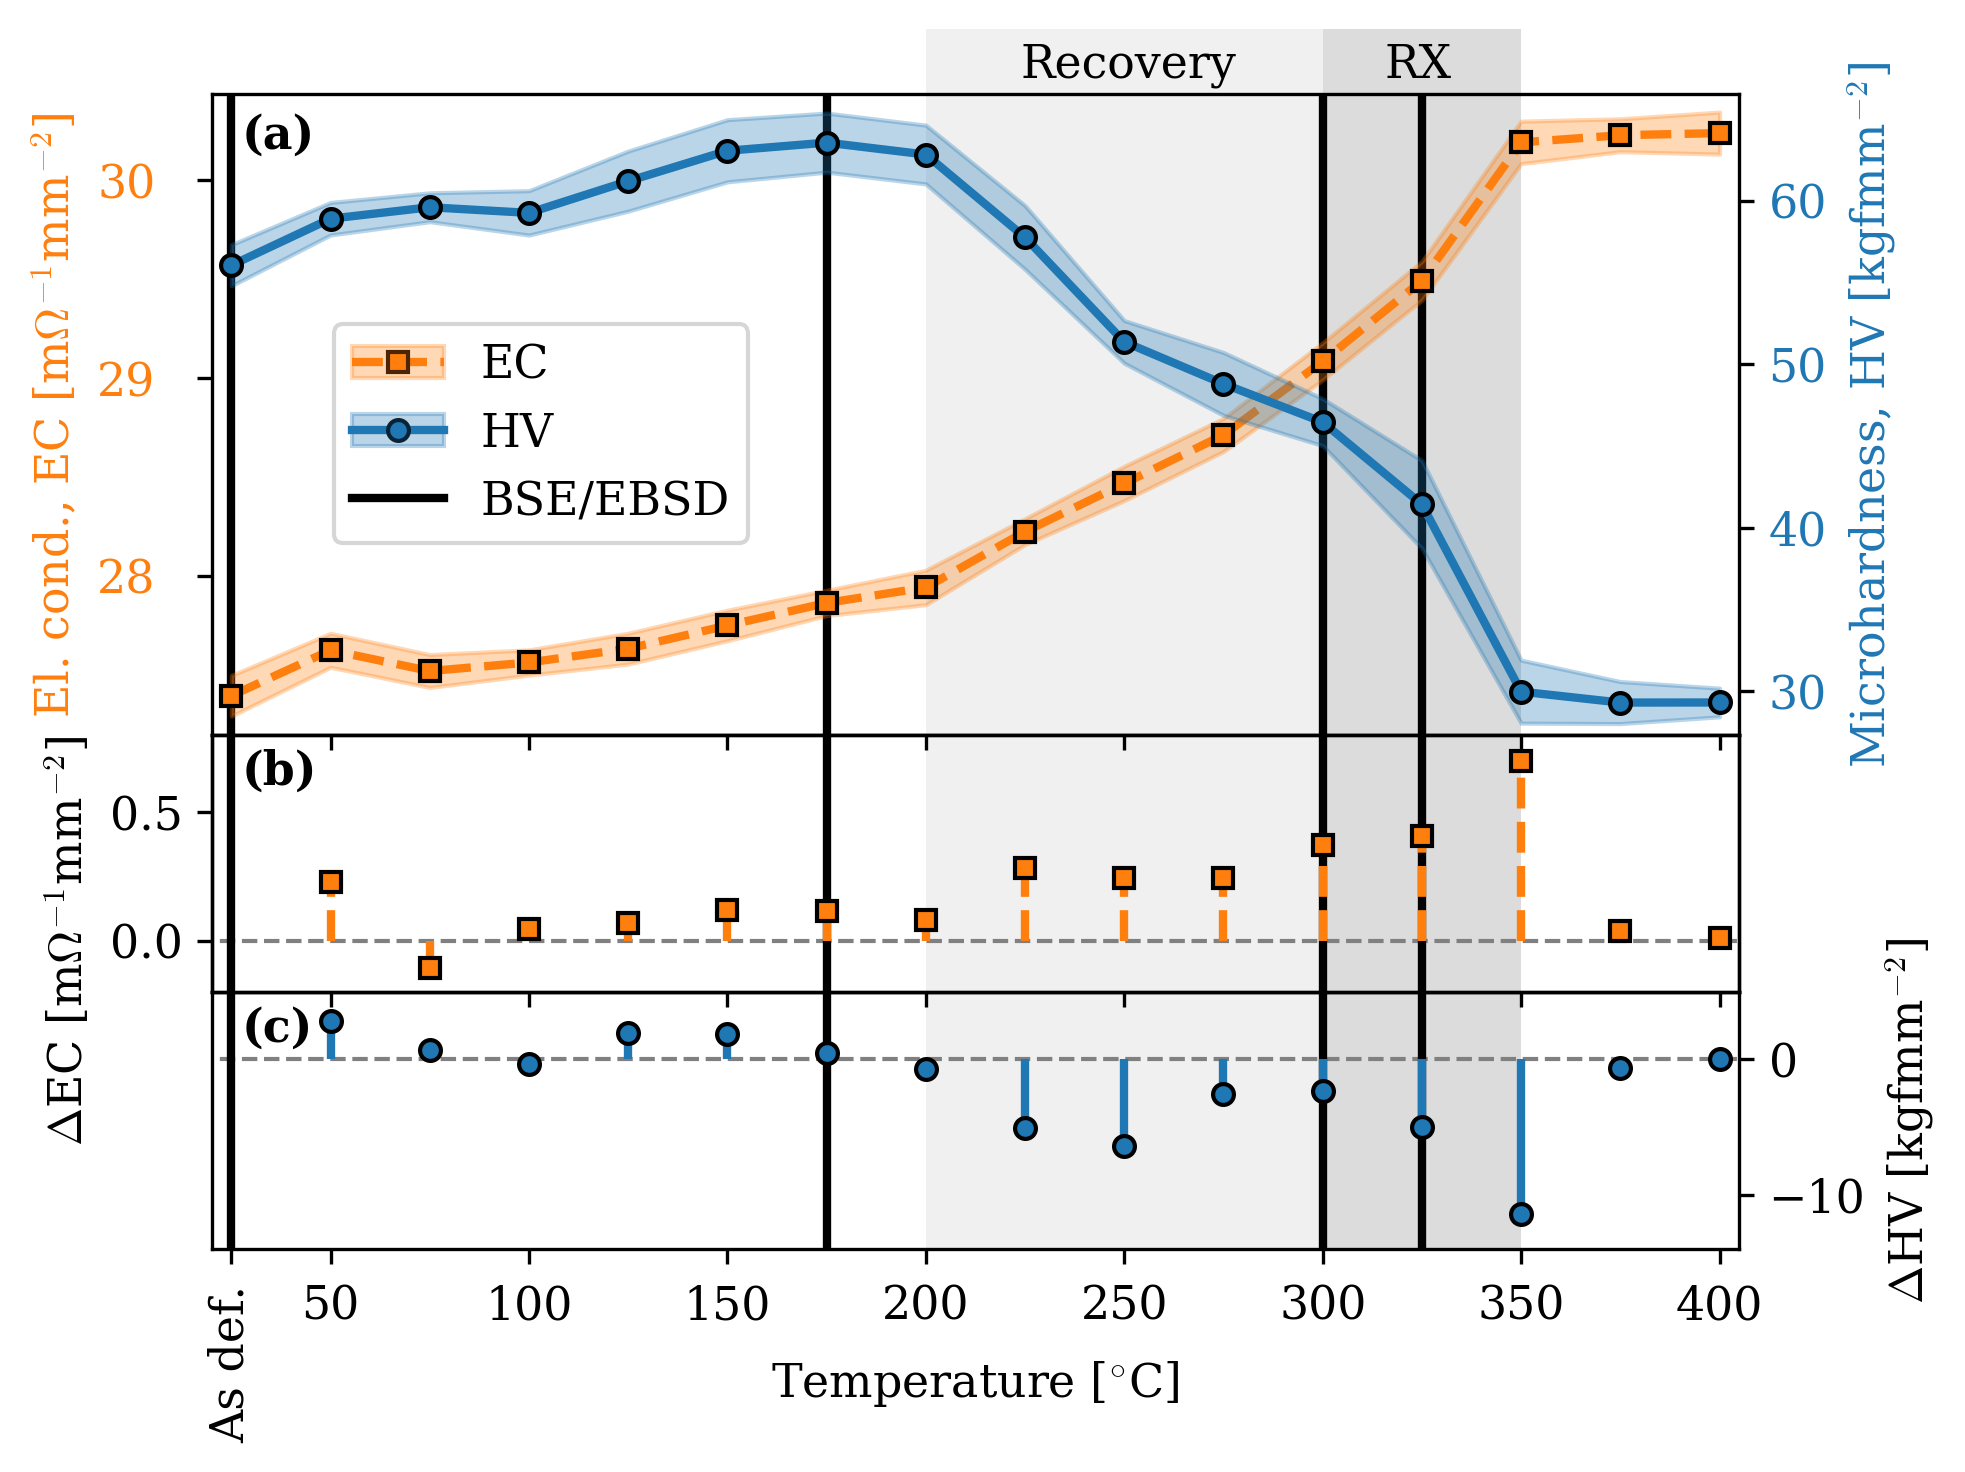

In [8]:
# EC/HV diff.
ec_diff = np.insert(np.diff(ec.ec).astype(float), 0, np.nan)
hv_diff = np.insert(np.diff(hv.hv).astype(float), 0, np.nan)

# Create figure with a grid
fig = plt.figure(figsize=(23, 5))
gs = fig.add_gridspec(3, 3, height_ratios=[2.5, 1, 1])
plot_kw = dict(clip_on=False, zorder=3, markeredgecolor="k", lw=2)

ax2 = fig.add_subplot(gs[2, 0])
ax0_ec = fig.add_subplot(gs[0, 0], sharex=ax2)
ax1 = fig.add_subplot(gs[1, 0], sharex=ax2)

# Tick properties
xtick_loc0 = np.array([0, 1, 3, 5, 7, 9, 11, 13, 15])
xtick_numbered_n = len(xtick_loc0) - 5
xtick_labels0 = [
    "As def.",
    "50", "100", "150", "200", "250", "300", "350", "400",
]
xtick_rotations = [90,] + ["horizontal"] * xtick_numbered_n + [len(hv) - 1]
xtick_alignments = ["center",] * 1 + ["center"] * xtick_numbered_n

# Uncertainty
hv_std_upper = (hv.hv + 2*hv.hv_std).astype(float)
hv_std_lower = (hv.hv - 2*hv.hv_std).astype(float)
ec_std_upper = (ec.ec + 2*ec.ec_std).astype(float)
ec_std_lower = (ec.ec - 2*ec.ec_std).astype(float)

# Plot EC
ec_color = "C1"
p1 = ax0_ec.plot(ec.index, ec.ec, "--s", color=ec_color, **plot_kw)
p2 = ax0_ec.fill_between(x=ec.index, y1=ec_std_upper, y2=ec_std_lower, color=ec_color, alpha=0.3)
ax0_ec.set_ylabel("El. cond., EC [m$\Omega^{-1}$mm$^{-2}$]", color=ec_color)

# Plot HV
hv_color = "C0"
ax0_hv = ax0_ec.twinx()
p3 = ax0_hv.plot(hv.index, hv.hv, "-o", color=hv_color, **plot_kw)
p4 = ax0_hv.fill_between(x=hv.index, y1=hv_std_upper, y2=hv_std_lower, color=hv_color, alpha=0.3)
p5 = ax0_hv.plot(np.nan, "--o", color=hv_color)
ax0_hv.set_ylabel("Microhardness, HV [kgfmm$^{-2}$]", color=hv_color)
ax0_hv.set_frame_on(False)

# Plot EC difference
markerline1, stemline1, _ = ax1.stem(ec.index, ec_diff, bottom=0, linefmt="--" + ec_color, markerfmt=ec_color + "s", basefmt="none")
markerline1.set_markeredgecolor("k")
stemline1.set_linewidth(2)
ax1.plot([-10, 20], [0, 0], "--", c="gray", zorder=0)
ax1.set_ylim(-0.2, 0.8)
ax1.set_ylabel("$\Delta$EC [m$\Omega^{-1}$mm$^{-2}$]", y=0.2)

# Plot HV difference
markerline2, stemline2, _ = ax2.stem(hv.index, hv_diff, bottom=0, linefmt="-" + hv_color, markerfmt=hv_color + "o", basefmt="none")
markerline2.set_markeredgecolor("k")
stemline2.set_linewidth(2)
ax2.plot([-10, 20], [0, 0], "--", c="gray", zorder=0)
ax2.set_ylim(-14, 5)
ax2.set_ylabel("$\Delta$HV [kgfmm$^{-2}$]")

# Axis limits
hv_min = hv.hv.min() - 2
hv_max = hv.hv.max() + 3
ec_min = ec.ec.min() - 0.2
ec_max = ec.ec.max() + 0.2
ax0_ec.set_ylim([ec_min, ec_max])
ec_y_values = [28, 29, 30]
ax0_ec.set_yticks(ec_y_values)
ax0_ec.set_yticklabels(ec_y_values)
ax0_hv.set_ylim([hv_min, hv_max])
ax2.set_xlim([hv.index.start - 0.2, hv.index.stop - 0.8])

# Tick parameters
ax0_ec.tick_params(axis="x", labelbottom=False)
ax1.tick_params(axis="x", labelbottom=False)
ax2.set_xticks(xtick_loc0)
ax2.set_xticklabels(xtick_labels0)
ax2.tick_params(axis="x", pad=5)
ax0_ec.tick_params(axis="y", labelcolor=ec_color, pad=10)
ax0_hv.tick_params(axis="y", labelcolor=hv_color)
# With no vertical spacing between subplots, ax0's x ticks aren't visible, so
# we add extra ticks to the top of ax1
ax11 = ax1.twiny()
ax11.set_xlim(ax1.get_xlim())
ax11.set_xticks(ax1.get_xticks())
ax11.set_xticklabels([])
ax11.xaxis.tick_top()
ax11.tick_params(axis="x", which="both", direction="in")
# Align x tick labels
for label, tick, rot, align in zip(
    ax2.get_xmajorticklabels(),
    ax2.get_xaxis().get_major_ticks(),
    xtick_rotations,
    xtick_alignments,
):
    label.set_rotation(rot)
    label.set_horizontalalignment(align)
# Move HV difference y ticks to the right
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

# Conditions studied by BSE/EBSD
for condition in [0, 6, 11, 12]:
    p5 = ax0_ec.axvline(condition, **bse_ebsd_kw)
    ax1.axvline(condition, **bse_ebsd_kw)
    ax2.axvline(condition, **bse_ebsd_kw)

# Subfigure labels
x_pos = 0.02
ax0_ec.text(x_pos, 0.9, "(a)", transform=ax0_ec.transAxes, **title_kw)
ax1.text(x_pos, 0.95, "(b)", transform=ax1.transAxes, ha="left", va="top", fontweight="bold")
ax2.text(x_pos, 0.95, "(c)", transform=ax2.transAxes, ha="left", va="top", fontweight="bold")

# EC/HV x axis labels
ax2.set_xlabel("Temperature [$^{\circ}$C]", labelpad=-20)
ax2.set_xticks(xtick_loc0)
ax2.set_xticklabels(xtick_labels0);

# Legend
ax0_ec.legend(
    [(p1[0], p2), (p3[0], p4), p5],
    ["EC", "HV", "BSE/EBSD"],
    loc=(0.08, 0.3),
)

# Highlight regions of recovery and recrystallization
ax0_ec.axvspan(xmin=7, xmax=11, ymax=1.1, fc=(240 / 255,) * 3, zorder=-5, clip_on=False)
ax0_ec.axvspan(xmin=11, xmax=13, ymax=1.1, fc=(220 / 255,) * 3, zorder=-5, clip_on=False)
ax1.axvspan(xmin=7, xmax=11, ymax=1.1, fc=(240 / 255,) * 3, zorder=-5)
ax1.axvspan(xmin=11, xmax=13, ymax=1.1, fc=(220 / 255,) * 3, zorder=-5)
ax2.axvspan(xmin=7, xmax=11, ymax=1.1, fc=(240 / 255,) * 3, zorder=-5)
ax2.axvspan(xmin=11, xmax=13, ymax=1.1, fc=(220 / 255,) * 3, zorder=-5)
ax0_ec.text(0.6, 1.01, "Recovery", transform=ax0_ec.transAxes, ha="center", va="bottom")
ax0_ec.text(0.79, 1.01, "RX", transform=ax0_ec.transAxes, ha="center", va="bottom")

# Save figure
fig.subplots_adjust(wspace=0.25, hspace=0)
fig.savefig(os.path.join(dir_article, "rx_kinetics/ec_hv.pdf"), **savefig_kw)

Macrotexture

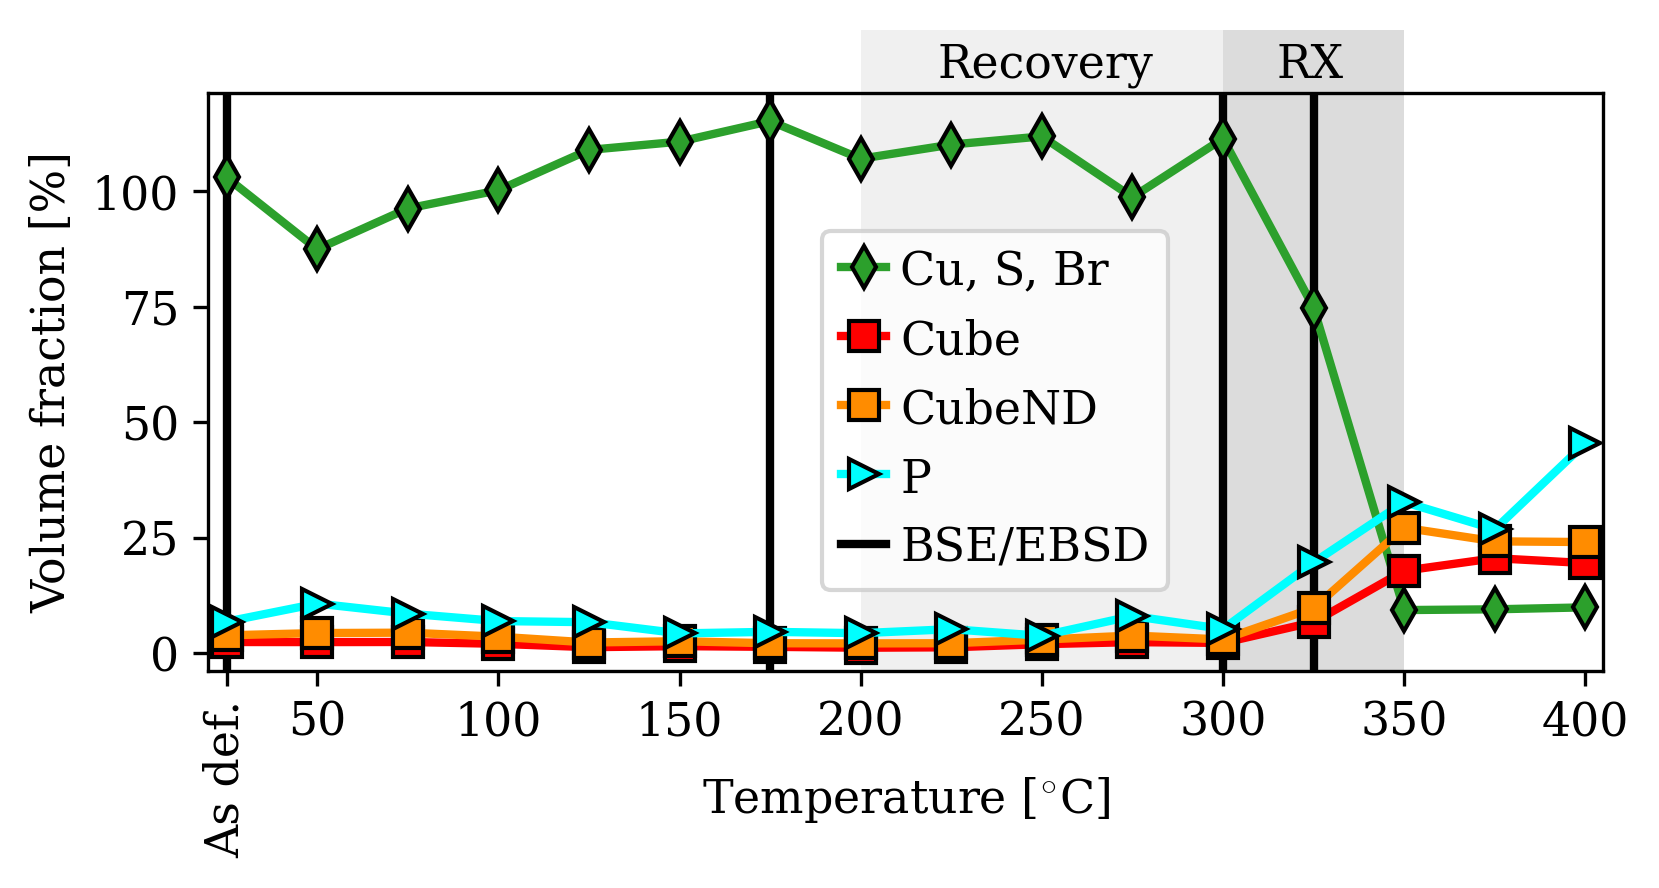

In [9]:
# Tick properties
xtick_loc1 = np.array([0, 1, 3, 5, 7, 9, 11, 13, 15])
xtick_numbered_n = len(xtick_loc1) - 2
xtick_labels1 = [
    "As def.",
    "50", "100", "150", "200", "250", "300", "350", "400",
]
xtick_rotations = [90] + ["horizontal"] * (xtick_numbered_n + 1)

# Texture component descriptions
names = ["Cu, S, Br", "Cube", "CubeND", "P"]
marker_kwds = dict(markersize=7, markeredgecolor="k")

fig, ax = plt.subplots(figsize=(6, 2.5))
for data, name in zip([texture.deform, texture.cube, texture.cubend, texture.p], names):
    ax.plot(
        texture.index,
        data,
        f"{comp_markers[name]}-",
        color=comp_colors[name],
        label=name,
        zorder=3,
        clip_on=False,
        lw=2,
        **marker_kwds,
    )

# Y limits
m_values = [texture.p.values, texture.cube.values, texture.cubend.values, texture.deform.values]
y_lim = [np.nanmin(m_values) - 5, np.nanmax(m_values) + 6]
ax.set_ylim(y_lim)

ax.set_xlabel("Temperature [$^{\circ}$C]", labelpad=-20)
ax.set_ylabel("Volume fraction [%]")

# Tick parameters
ax.set_xlim([texture.index.start - 0.2, texture.index.stop - 0.8])
ax.set_xticks(xtick_loc1)
ax.set_xticklabels(xtick_labels1)
for label, rot in zip(ax.get_xmajorticklabels(), xtick_rotations):
    label.set_rotation(rot)

# Conditions studied by BSE/EBSD
conditions = [0, 6, 11, 12]
for condition in conditions:
    if condition == conditions[-1]:
        label = "BSE/EBSD"
    else:
        label=None
    ax.axvline(condition, label=label, **bse_ebsd_kw)

# Legend
ax.legend(
    loc=(0.44, 0.14),
    handlelength=1,
    handleheight=1,
    handletextpad=0.3,
)

# Highlight regions of recovery and recrystallization
ax.axvspan(xmin=7, xmax=11, ymax=1.11, fc=(240 / 255,) * 3, zorder=-5, clip_on=False)
ax.axvspan(xmin=11, xmax=13, ymax=1.11, fc=(220 / 255,) * 3, zorder=-5, clip_on=False)
ax.text(0.6, 1.01, "Recovery", transform=ax.transAxes, ha="center", va="bottom")
ax.text(0.79, 1.01, "RX", transform=ax.transAxes, ha="center", va="bottom")

fig.savefig(os.path.join(dir_article, "macrotexture/volume_fractions.pdf"), **savefig_kw)

Print selected values

In [10]:
ec.iloc[[0, 6, 11, 12, 13, 14, 15]]

,sample,t,T,hold,ec,ec_std,ec_temp,ec_diff
0,as deformed,0,25,0,27.392333,0.05144,23.62,-0.032667
6,7,3,175,0,27.862,0.032099,23.38,0.114
11,12,5.5,300,0,29.084667,0.046958,23.588,0.372667
12,13,6,325,0,29.492333,0.048897,23.588,0.407667
13,14,6.5,350,0,30.192333,0.053799,23.62,0.7
14,15,7,375,0,30.228667,0.041584,23.62,0.036333
15,16,7.5,400,0,30.239333,0.053171,23.62,0.010667


In [11]:
hv.iloc[[0, 6, 11, 12, 13, 14, 15]]

,sample,t,T,hold,hv1,hv2,hv3,hv4,hv5,hv6,hv7,hv8,hv9,hv10,hv,hv_std,dwell_time,load,diff
0,as deformed,0,25,0,56.34,55.79,55.66,56.21,57.4,55.6,56.69,55.94,55.62,55.28,56.053,0.628385,15,1,23.106
6,7,3,175,0,62.56,62.77,62.23,63.91,63.31,64.26,63.82,63.18,65.07,64.45,63.556,0.903822,15,1,0.498
11,12,5.5,300,0,45.97,46.16,46.73,46.31,47.71,46.34,47.39,45.88,45.29,46.73,46.451,0.718385,15,1,-2.342
12,13,6,325,0,42.85,42.59,40.48,40.84,42.38,39.21,42.35,41.94,39.38,42.17,41.419,1.345729,15,1,-5.032
13,14,6.5,350,0,32.08,29.51,29.8,29.36,30.79,29.48,30.8,29.45,29.45,28.9,29.962,0.963279,15,1,-11.457
14,15,7,375,0,30,29.49,28.35,28.52,28.9,30.45,29.57,29.2,29,29.46,29.294,0.642706,15,1,-0.668
15,16,7.5,400,0,29,28.3,29.45,29.49,29.21,29.36,29.49,29.97,29.17,29.55,29.299,0.437758,15,1,0.005


In [12]:
texture.iloc[[0, 6, 12, 13, 14, 15]]

,t,T,hold,textureindex,entropy,odfmax,br,cu,s,deform,...,NaN,p/cubend,p/cube,NaN,diff br,diff cu,diff s,diff cube,diff cubend,diff p
0,0,25,0,3.8236,-0.86,11.6922,30.0864,39.2585,33.6371,102.982,...,NaN,1.753116,2.780001,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,3,175,0,4.5957,-0.9862,14.378,31.0213,45.8139,38.3377,115.1729,...,NaN,2.118142,3.265457,NaN,2.7992,1.1754,0.4794,-0.1439,-0.435,0.3409
12,6,325,0,2.9794,-0.6771,8.5761,20.0603,28.5819,26.1821,74.8243,...,NaN,2.002768,2.9037,NaN,-9.9237,-15.7746,-10.8729,4.4985,6.8036,14.3947
13,6.5,350,0,5.3084,-0.8392,21.1844,4.7829,1.096,3.5059,9.3848,...,NaN,1.20391,1.830237,NaN,-15.2774,-27.4859,-22.6762,11.1126,17.3711,13.0619
14,7,375,0,5.4531,-0.7809,37.4044,2.8745,2.3435,4.3297,9.5477,...,NaN,1.107634,1.303165,NaN,-1.9084,1.2475,0.8238,2.7175,-2.9523,-5.8887
15,7.5,400,0,5.7567,-0.9348,27.35,3.5719,1.9587,4.4414,9.972,...,NaN,1.887449,2.32689,NaN,0.6974,-0.3848,0.1117,-1.058,-0.1442,18.636


In [13]:
texture_huang_400c = {"p": 46.2, "cubend": 11.4, "cube": 6.9}
texture_here_400c = {"p": texture.iloc[15]["p"], "cubend": texture.iloc[15]["cubend"], "cube": texture.iloc[15]["cube"]}

print((
    "Here (Huang)\n"
    f"* p/cubend: {texture_here_400c['p'] / texture_here_400c['cubend']:.2f} ({texture_huang_400c['p'] / texture_huang_400c['cubend']:.2f})\n"
    f"* p/cube:   {texture_here_400c['p'] / texture_here_400c['cube']:.2f} ({texture_huang_400c['p'] / texture_huang_400c['cube']:.2f})"
))

Here (Huang)
* p/cubend: 1.89 (4.05)
* p/cube:   2.33 (6.70)


## Particle statistics

From all BSE images, not just the regions of interest (ROIs) in the corrected EBSD maps

In [14]:
regions_kw = dict(
    dx=step_size["bse"] * 1e-3,
    dy=step_size["bse"] * 1e-3,
    scan_unit="um",
    background_label=0
)

Read data generated in `bse3_particle_detection.ipynb`, combining them into
one dataset per temperature, thus loosing spatial information

In [15]:
ecd_max = 0
particles = {}
total_area = np.zeros(4)

for i, sample in enumerate(identifier):
    particle_area = []
    for j in range(3):
        labels = np.load(os.path.join(
            dir_data, f"prover/{sample}/{j + 1}/partdet/bse_labels_filled_filtered.npy"
        ))

        regions = MapRegions(labels, **regions_kw)
        
        total_area[i] += np.prod(regions.map_shape) * regions.dx * regions.dy
        
        particle_area.append(regions.area)

    area = np.hstack(particle_area)
    particles_i = pd.DataFrame(data=area, columns=["area"])
    particles_i["radius"] = np.sqrt(particles_i.area / np.pi)
    particles_i["ecd"] = 0.816 * 2 * particles_i.radius
    
    ecd_max_i = particles_i.ecd.max()
    if ecd_max_i > ecd_max:
        ecd_max = ecd_max_i
    
    particles[sample] = particles_i

Cumulative distribution function of particle sizes and area weighted histogram
of particle sizes $d$

In [49]:
14 / (12 / 3)

3.5

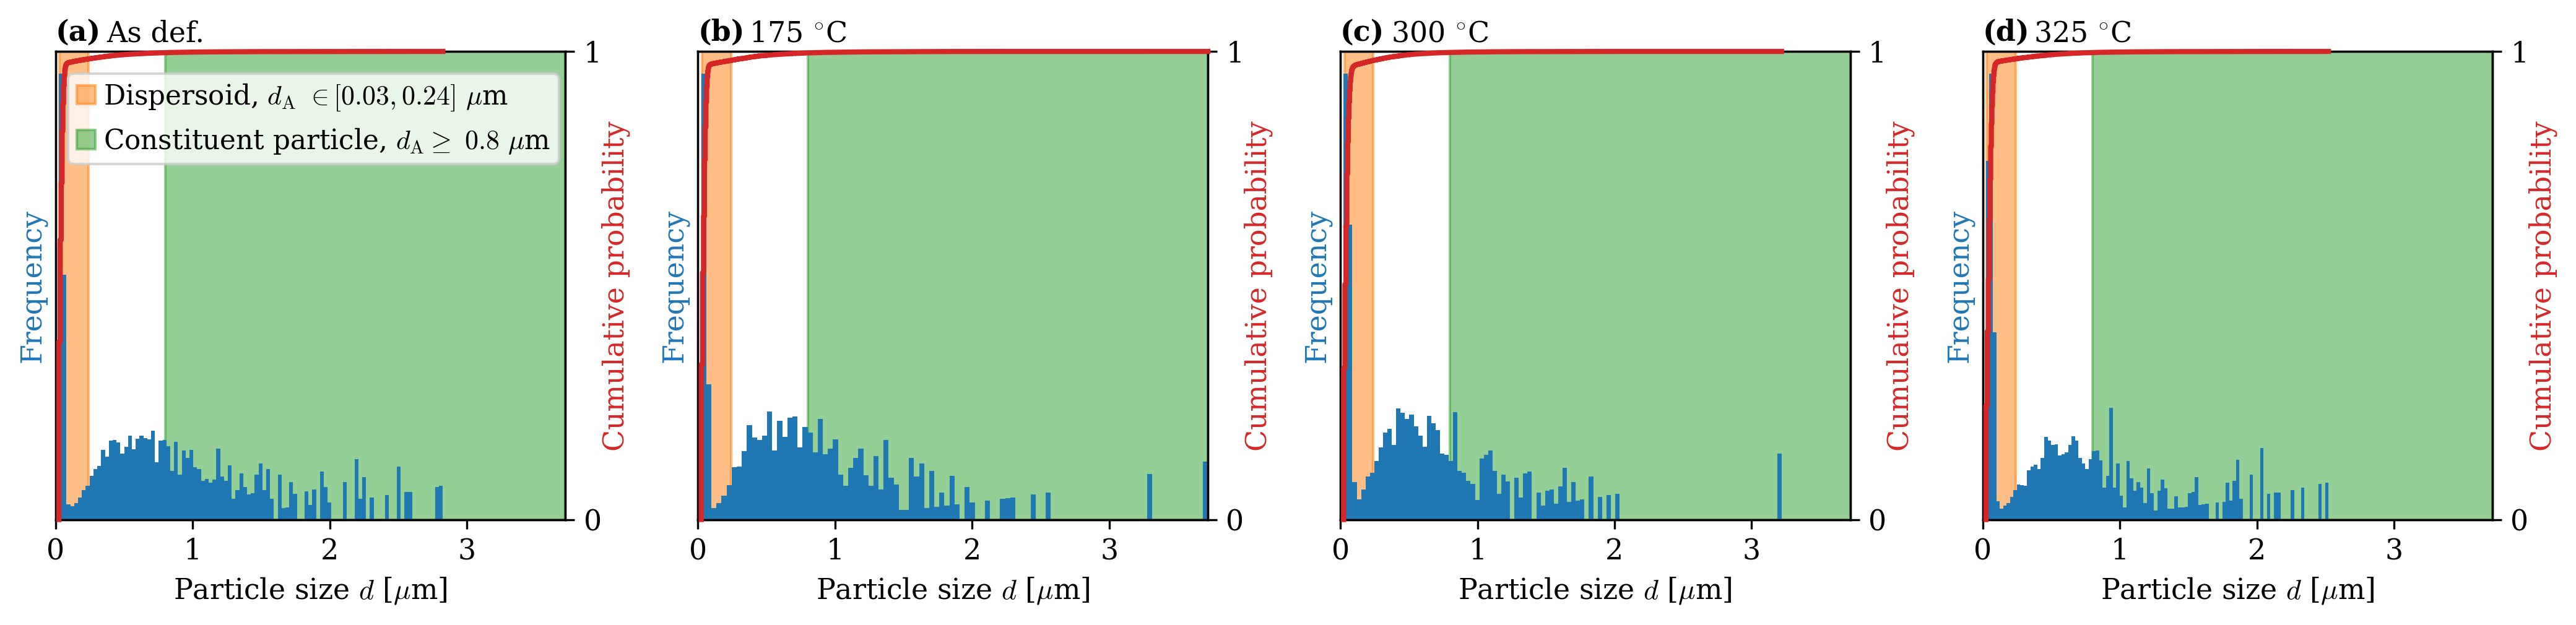

In [103]:
fig, ax = plt.subplots(ncols=4, figsize=(14, 3.5))
labels = ["a", "b", "c", "d"]

for i, sample in enumerate(particles.keys()):
    ecd = particles[sample].ecd
    ecd_sorted = np.sort(ecd)
    ecd_cdf = np.arange(particles[sample].shape[0]) / particles[sample].shape[0]
    
    par = ax[i].twinx()
    *_, p1 = ax[i].hist(ecd, bins=100, weights=particles[sample].area)
    p2, = par.plot(ecd_sorted, ecd_cdf, "C3", clip_on=False, zorder=3, linewidth=2)
    
    # Labels
    ax[i].set_xlabel(r"Particle size $d$ [$\mu$m]")
    ax[i].set_ylabel("Frequency", labelpad=0)
    ax[i].yaxis.get_label().set_color(p1[0].get_facecolor())
    par.set_ylabel("Cumulative probability", labelpad=0)
    par.yaxis.get_label().set_color(p2.get_color())
    
    # Axes ticks and limits
    ax[i].set_yticks([])
    ax[i].set_xlim(0, ecd_max)
    par.set_ylim(0, 1)
    par.set_yticks([0, 1])
    
    # Regions
    ax[i].axvspan(
        xmin=dispersoid_threshold_min,
        xmax=dispersoid_threshold_max,
        color="C1",
        alpha=0.5,
        zorder=0,
        label=r"Dispersoid, $d_{\mathrm{A}}$ $\in " + f"[{dispersoid_threshold_min:.2f}, {dispersoid_threshold_max:.2f}]" + r"$ $\mu$m",
    )
    ax[i].axvspan(
        xmin=constituent_threshold,
        xmax=ecd_max,
        color="C2",
        alpha=0.5,
        zorder=0,
        label=r"Constituent particle, $d_{\mathrm{A}} \geq$ " + f"${constituent_threshold:.1}$" + r" $\mu$m",
    )
    
    # Title
    ax[i].text(0, 1.01, f"({labels[i]})", ha="left", va="bottom", transform=ax[i].transAxes, fontweight="bold")
    ax[i].text(0.1, 1.008, titles[i], ha="left", va="bottom", transform=ax[i].transAxes)

ax[0].legend(
    loc=(0.025, 0.76),
    handlelength=0.7,
    handletextpad=0.3,
    borderpad=0.3,
    fontsize=plt.rcParams["font.size"] - 0.5
)
fig.tight_layout()
fig.savefig(os.path.join(dir_article, "particle_stats/particle_size_hist.pdf"), **savefig_kw)

Other particle statistics:

Particle volume fraction $F_V$

$$
F_V = \frac{\sum_i^n A_i}{A_{\mathrm{total}}}.
$$

Number of particles per unit volume $N_V$

$$
N_V = \frac{3F_V}{4\pi r^3}.
$$

Number of particles crossing unit area $N_S$

$$
N_S = 2rN_v = \frac{3F_V}{2\pi r^2}.
$$

Distance to nearest neighboring particle assuming particles distributed in a grid $\lambda$

$$
\lambda = \frac{1}{\sqrt{N_S}},
$$

In [17]:
columns=[
    "total_area",
    "n", "n_c", "n_d",
    "fv", "fv_c", "fv_d",
    "ecd_mean", "ecd_var", "ecd_confint",
    "ecd_mean_c", "ecd_var_c", "ecd_confint_c",
    "ecd_mean_d", "ecd_var_d", "ecd_confint_d",
    "nv_mean", "nv_std",
    "nv_mean_c", "nv_std_c",
    "nv_mean_d", "nv_std_d",
    "ns_mean", "ns_std",
    "ns_mean_c", "ns_std_c",
    "ns_mean_d", "ns_std_d",
    "nn_distance_grid", "nn_distance_grid_c", "nn_distance_grid_d",
]
particle_stats = pd.DataFrame(
    np.zeros((len(identifier), len(columns))),
    index=identifier,
    columns=columns,
)
particle_stats["total_area"] = total_area

for sample in particles.keys():
    area_i = particles[sample].area
    ecd_i = particles[sample].ecd
    radius_i = particles[sample].radius
    
    # Boolean masks for all, constituent and dispersoid particles
    mask_all = np.ones(ecd_i.size, dtype=bool)
    mask_c = ecd_i >= constituent_threshold
    mask_d = (ecd_i >= dispersoid_threshold_min) & (ecd_i <= dispersoid_threshold_max)

    for mask, suffix in zip([mask_all, mask_c, mask_d], ["", "_c", "_d"]):
        area_mask = area_i[mask]
        ecd_mask = ecd_i[mask]
        radius_mask = radius_i[mask]

        # Number of particles
        particle_stats.loc[sample]["n" + suffix] = len(area_mask)
        # Volume fraction
        fv = area_mask.sum() / particle_stats.loc[sample]["total_area"]
        particle_stats.loc[sample]["fv" + suffix] = fv
        # Area weighted particle size
        ecd_mean = np.average(ecd_mask, weights=area_mask)
        particle_stats.loc[sample]["ecd_mean" + suffix] = ecd_mean
        ecd_var = np.average((ecd_mask - ecd_mean) ** 2, weights=area_mask)
        particle_stats.loc[sample]["ecd_var" + suffix] = ecd_var
        particle_stats.loc[sample]["ecd_confint" + suffix] = 1.96 * np.sqrt(ecd_var) / np.sqrt(ecd_var.size)
        # Number of particles per unit volume
        nv = 3 * fv / (4 * np.pi * radius_mask ** 3)
        particle_stats.loc[sample]["nv_mean" + suffix] = nv.mean()
        particle_stats.loc[sample]["nv_std" + suffix] = nv.std()
        # Number of particles per unit area
        ns = 2 * radius_mask * nv
        particle_stats.loc[sample]["ns_mean" + suffix] = ns.mean()
        particle_stats.loc[sample]["ns_std" + suffix] = ns.std()
        # Particle distance (grid)
        particle_stats.loc[sample]["nn_distance_grid" + suffix] = 1 / np.sqrt(ns.mean())

print(particle_stats[["ecd_mean_c", "ns_mean_c", "nn_distance_grid_c"]])
print(particle_stats[["ecd_mean_d", "ns_mean_d", "nn_distance_grid_d"]])

      ecd_mean_c  ns_mean_c  nn_distance_grid_c
0s      1.492928   0.011390            9.369783
175c    1.487248   0.011474            9.335552
300c    1.363459   0.007252           11.742597
325c    1.424886   0.010192            9.905406
      ecd_mean_d  ns_mean_d  nn_distance_grid_d
0s      0.070047   2.701585            0.608402
175c    0.069885   2.421056            0.642684
300c    0.078322   2.529665            0.628736
325c    0.069982   3.203512            0.558710


Number of particles

In [18]:
particle_stats[["n", "n_c", "n_d"]]

,n,n_c,n_d
0s,117585.0,305.0,71039.0
175c,85070.0,273.0,55265.0
300c,68308.0,153.0,44914.0
325c,78925.0,197.0,58463.0


Statistics for particles (all, constituent and dispersoids)

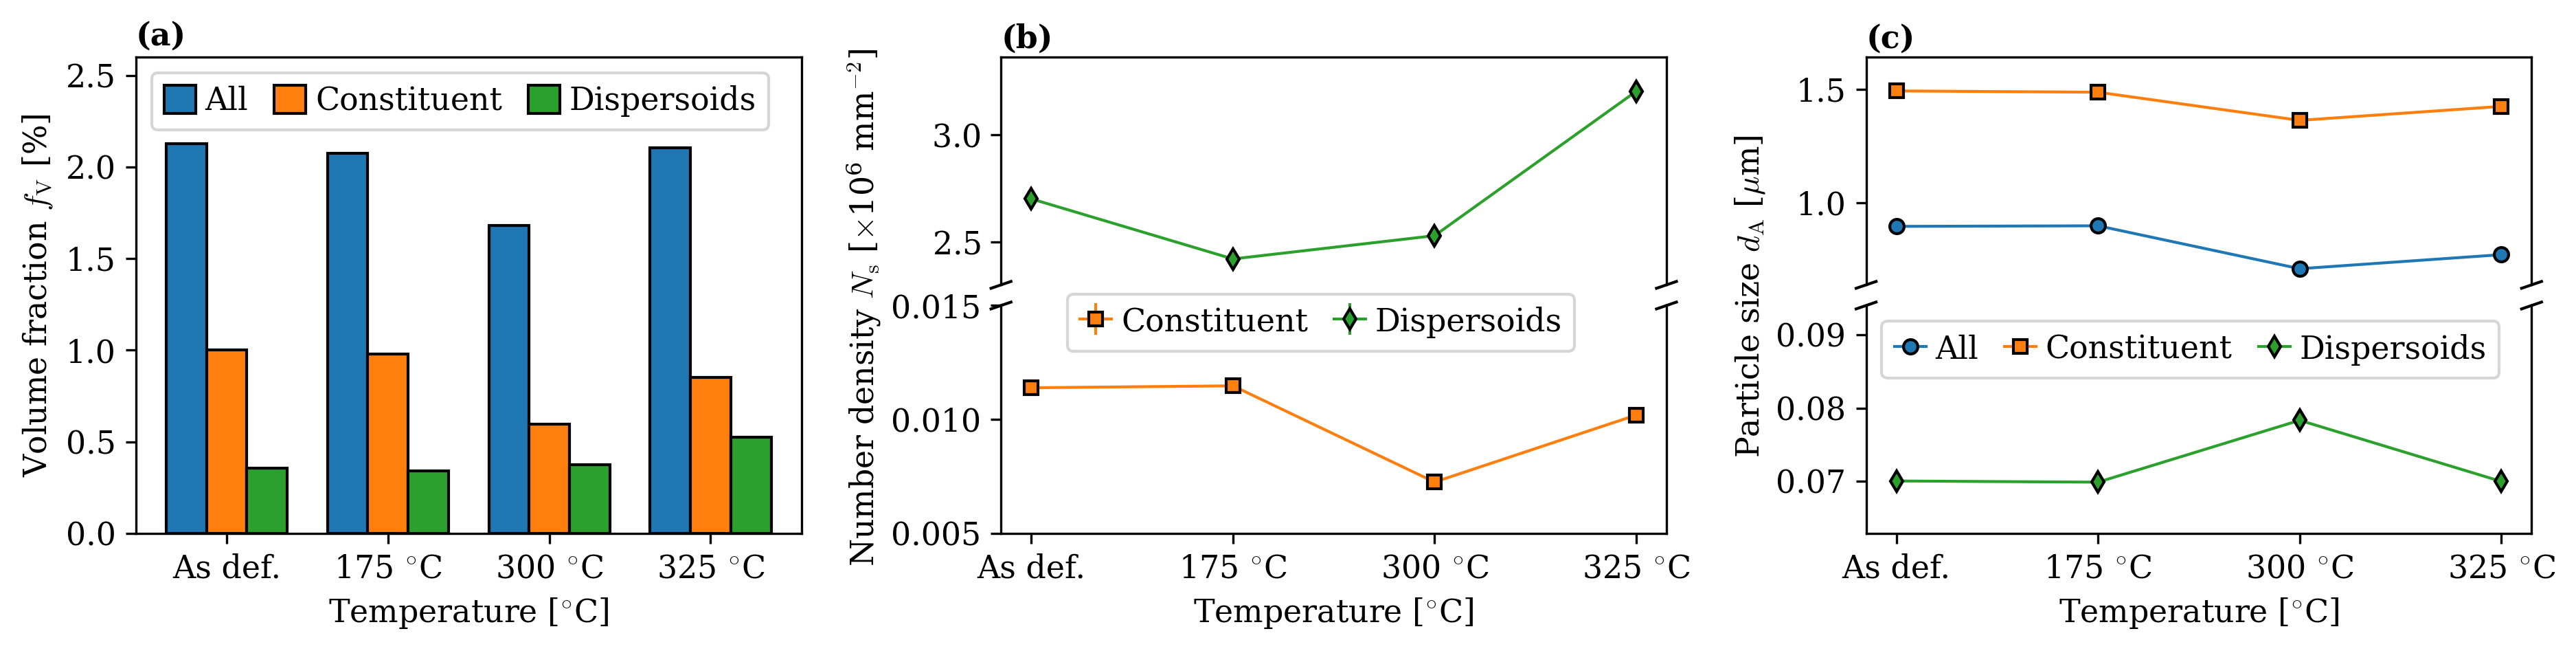

In [19]:
x = np.arange(len(particle_stats))
bar_width = 0.25
bar_kw = dict(width=bar_width, ec="k")

markers = ["o", "s", "d"]

# Set up figure
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 3))

# (a) Volume fraction
# -------------------
ax0.bar(x - bar_width, 100 * particle_stats.fv, label="All", **bar_kw)
ax0.bar(x, 100 * particle_stats.fv_c, label="Constituent", **bar_kw)
ax0.bar(x + bar_width, 100 * particle_stats.fv_d, label="Dispersoids", **bar_kw)
ax0.set_ylim(0, 2.6)
ax0.set_xticks(x)
ax0.set_xticklabels(titles)
ax0.set_xlabel("Temperature [$^{\circ}$C]")
ax0.set_ylabel("Volume fraction $f_{\mathrm{V}}$ [%]")
ax0.text(0, 1.01, "(a)", transform=ax0.transAxes, **title_kw)
ax0.legend(
    loc="upper left",
    ncol=3,
    handlelength=1,
    handleheight=1,
    handletextpad=0.3,
    columnspacing=0.83
)

# (b) Number density of particles N_s
# -----------------------------------
divider = make_axes_locatable(ax1)
ax12 = divider.new_vertical(size="100%", pad=0.1)
fig.add_axes(ax12)

for data, err, label, marker, c in zip(
    [particle_stats.ns_mean_c, particle_stats.ns_mean_d],
    [particle_stats.ns_std_c, particle_stats.ns_std_d],
    ["Constituent", "Dispersoids"],
    markers[1:],
    ["C1", "C2"],
):
    ax1.errorbar(x, data * 1e6, yerr=2 * err, label=label, color=c, marker=marker, markeredgecolor="k")
    ax12.errorbar(x, data * 1e6, yerr=2 * err, label=label, color=c, marker=marker, markeredgecolor="k")

ax12.tick_params(bottom=False, labelbottom=False)
ax1.spines["top"].set_visible(False)
ax12.spines["bottom"].set_visible(False)
#ax1.set_ylim(0.005e6, 0.016e6)
#ax12.set_ylim(4.5e6, 6e6)
ax1.set_ylim(particle_stats.ns_mean_c.min() * 1e6 * 0.95, particle_stats.ns_mean_c.max() * 1e6 * 1.15)
ax12.set_ylim(particle_stats.ns_mean_d.min() * 1e6 * 0.95, particle_stats.ns_mean_d.max() * 1e6 * 1.05)
d = 0.015
kwargs = dict(transform=ax12.transAxes, color='k', clip_on=False)
ax12.plot((-d, d), (-d, d), **kwargs)
ax12.plot((1 - d, 1 + d), (-d, d), **kwargs)
kwargs.update(transform=ax1.transAxes)
ax1.plot((-d, d), (1 - d, 1 + d), **kwargs)
ax12.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

# Axes and labels
ax1.set_xticks(x)
ax1.set_xticklabels(titles)
#ytick_labels = ["0.025", "0.030"]
ytick_labels = ["0.005", "0.010", "0.015"]
ax1.set_yticks([float(i) * 1e6 for i in ytick_labels])
ax1.set_yticklabels(ytick_labels)
ax1.set_xlabel("Temperature [$^{\circ}$C]")
ax12.text(0, 1.01, "(b)", transform=ax12.transAxes, **title_kw)
# Get exponent of y axis (must draw before getting it)
ax12.ticklabel_format(useMathText=True)
plt.draw()
exp = ax12.get_yaxis().get_offset_text().get_text()
ax12.get_yaxis().get_offset_text().set_visible(False)
ax12.set_ylabel("Number density $N_{\mathrm{s}}$ [" + exp + r" mm$^{-2}$]", y=-0.1, labelpad=17)

# Legend
ax1.legend(
    loc=(0.1, 0.8),
    ncol=2,
    handlelength=1,
    handleheight=1,
    handletextpad=0.3,
    columnspacing=0.83,
)

# (c) Area weighted average particle size d_A
# -------------------------------------------
divider = make_axes_locatable(ax2)
ax22 = divider.new_vertical(size="100%", pad=0.1)
fig.add_axes(ax22)

for data, label, marker in zip(
    [particle_stats.ecd_mean, particle_stats.ecd_mean_c, particle_stats.ecd_mean_d],
    ["All", "Constituent", "Dispersoids"],
    markers,
):
    ax2.plot(x, data, label=label, marker=marker, markeredgecolor="k")
    ax22.plot(x, data, label=label, marker=marker, markeredgecolor="k")

ax2.set_xticks(x)
ax2.set_xticklabels(titles)

ax22.tick_params(bottom=False, labelbottom=False)
ax2.spines["top"].set_visible(False)
ax22.spines["bottom"].set_visible(False)
#ax2.set_ylim(0.06, 0.085)
#ax22.set_ylim(0.6, 1.6)
ax2.set_ylim(particle_stats.ecd_mean_d.min() * 0.9, particle_stats.ecd_mean_d.max() * 1.2)
ax22.set_ylim(particle_stats.ecd_mean.min() * 0.9, particle_stats.ecd_mean_c.max() * 1.1)
d = 0.015
kwargs = dict(transform=ax22.transAxes, color='k', clip_on=False)
ax22.plot((-d, d), (-d, d), **kwargs)
ax22.plot((1 - d, 1 + d), (-d, d), **kwargs)
kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, d), (1 - d, 1 + d), **kwargs)
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

ax2.set_xlabel("Temperature [$^{\circ}$C]")
ax22.set_ylabel("Particle size $d_{\mathrm{A}}$ [$\mathrm{\mu}$m]", y=-0.05, labelpad=10)
ax22.text(0, 1.01, "(c)", transform=ax22.transAxes, **title_kw)
ax2.legend(
    loc="upper left",
    ncol=3,
    handlelength=1,
    handleheight=1,
    handletextpad=0.3,
    columnspacing=0.83
)

fig.subplots_adjust(wspace=0.3)
fig.savefig(os.path.join(dir_article, "particle_stats/particle_stats.pdf"), **savefig_kw)

In [20]:
particle_stats["ns_mean"]

0s      28.234542
175c    25.224842
300c    19.862795
325c    21.196891
Name: ns_mean, dtype: float64

In [21]:
particle_stats["ns_mean_d"].iloc[2] / particle_stats["ns_mean_d"].iloc[0]

0.9363633618565442

### Estimated Mn in solid solution

Evaluation based on considerations made by Zhao et al. (2013) ([doi](https://doi.org/10.1080/14786435.2013.794315))

$$
\frac{1}{EC} = 0.0267 + 0.032\mathrm{Fe_{ss}}\% + 0.033\mathrm{Mn_{ss}}\% + 0.0068\mathrm{Si_{ss}}\% + 0.0021 f_{\mathrm{V}},
$$

where we neglect the contributions from Fe and Si in solid solution (see above referenced paper for details)

In [22]:
ec_vals = ec.iloc[[0, 6, 11, 12]].ec.values.astype(float)
fe_pct = 0
si_pct = 0.01
particle_pct = 100 * particle_stats.fv.values.astype(float)

mn_pct = (1 / 0.033) * ((1 / ec_vals) - 0.0267 - (0.032 * fe_pct) - (0.0068 * si_pct) - (0.0021 * particle_pct))

print(mn_pct)

[0.15964523 0.14438955 0.12373894 0.08235206]


## Subgrain statistics

Read data generated with `MTEX`, combining them into one dataset per temperature, thus loosing spatial information

In [23]:
grains = {}
n_grains = {}
dist_to_gb_sorted = {}
dist_to_gb_cdf = {}

for sample in identifier:
    n_grains_sample = 0
    n_grains[sample] = np.zeros(3, dtype=int)
    for j in range(3):
        # Read data from file
        grains_j = pd.read_csv(
            os.path.join(dir_data, f"prover/{sample}/{j + 1}/mtex/grains.txt"),
            delimiter=","
        )
        
        # Add grains to existing frame, or create if first iteration.
        if j == 0:
            grains_i = grains_j
        else:
            # Make sure to give each grain a unique ID across all datasets by
            # incrementing the ID
            grains_j["#id"] += n_grains_sample

            grains_i = pd.concat((grains_i, grains_j))

        # Increment grain numer
        n_grains_sample += grains_j.shape[0]

        # Keep number of grains per dataset
        n_grains[sample][j] = grains_j.shape[0]

    # Relevant statistics
    grains_i["area"] = grains_i["size"] * 0.1 ** 2
    grains_i["radius"] = np.sqrt(grains_i.area / np.pi)
    grains_i["ecd"] = 0.816 * 2 * grains_i.radius
    grains_i["is_al"] = grains_i.phase == 1
    grains_i["is_rx"] = (
        grains_i.is_al
        & (grains_i.ecd > 4)  # 3 is too low
        & (grains_i.gos < np.deg2rad(1))  # 0.5 is too low, 2 is too high
        & (grains_i.xhab > 0.5)  # 0.75 is too high
    )

    # Change some data types
    grains_i["at_particle"] = grains_i["at_particle"].astype(bool)
    grains_i["at_constituent_particle"] = grains_i["at_constituent_particle"].astype(bool)

    grains[sample] = grains_i
    
    # Distance to grain boundary for dispersoids
    dist_to_gb_i = grains_i[
        ~grains_i.is_al
        & (grains_i.ecd >= dispersoid_threshold_min)
        & (grains_i.ecd <= dispersoid_threshold_max)
        & (grains_i.dist_to_gb != -1)
    ].dist_to_gb
    dist_to_gb_sorted[sample] = np.sort(dist_to_gb_i)
    dist_to_gb_cdf[sample] = np.arange(dist_to_gb_i.size) / dist_to_gb_i.size

Various statistics per temperature per texture component

In [24]:
# Data frame columns
columns = ["total_area", "n_subgrains_all"]
other_columns = [
    "fv",
    "n_grains",
    "n_grains_per_area",
    "ecd_mean", "ecd_var", "ecd_confint",
    "gos_mean", "gos_var", "gos_confint",
    "gam_mean", "gam_var", "gam_confint",
]
for col in other_columns:
    for comp_name in comp_names_low[:-1]:
        columns.append(col + "_" + comp_name)
# Empty data frame
grain_stats = pd.DataFrame(
    np.zeros((len(identifier), len(columns))),
    index=identifier,
    columns=columns,
)

for sample in identifier:
    # Grains at this temperature
    grains_i = grains[sample]
    
    # Consider only subgrains (not particles or recrystallized grains)
    grains_i = grains_i[(grains_i.phase == 1) & (~grains_i.is_rx)]

    # Grain stats (unfilled) at this temperature
    grain_stats_i = grain_stats.loc[sample]

    # Total area of grains at this temperature (in microns squared)
    grain_stats_i["total_area"] = grains_i.area.sum()

    # Number of subgrains
    grain_stats_i["n_subgrains_all"] = len(grains_i)
    
    # Component spresent, and how many there are of them, at this temperature
    ideal_unique_j, n_grains_j = np.unique(grains_i.ideal, return_counts=True)

    for comp_id in ideal_unique_j:
        # Grains of this component
        grains_j = grains_i[grains_i.ideal == comp_id]
        n_grains_j = len(grains_j)

        # Component name
        comp_name = comp_names_low[comp_id]

        # Volume fraction of component
        area_j = grains_j.area
        grain_stats_i["fv_" + comp_name] = area_j.sum() / grain_stats_i.total_area

        # Number of grains
        grain_stats_i["n_grains_" + comp_name] = n_grains_j
        grain_stats_i["n_grains_per_area_" + comp_name] = n_grains_j / grain_stats_i["total_area"]

        # ECD
        ecd_mean_j = np.average(grains_j.ecd, weights=area_j)
        ecd_var_j = np.average((grains_j.ecd - ecd_mean_j) ** 2, weights=area_j)
        grain_stats_i["ecd_mean_" + comp_name] = ecd_mean_j
        grain_stats_i["ecd_var_" + comp_name] = ecd_var_j
        grain_stats_i["ecd_confint_" + comp_name] = 1.96 * np.sqrt(ecd_var_j) / np.sqrt(n_grains_j)

        # GOS
        gos_mean_j = np.average(grains_j.gos, weights=area_j)
        gos_var_j = np.average((grains_j.gos - gos_mean_j) ** 2, weights=area_j)
        grain_stats_i["gos_mean_" + comp_name] = gos_mean_j
        grain_stats_i["gos_var_" + comp_name] = gos_var_j
        grain_stats_i["gos_confint_" + comp_name] = 1.96 * np.sqrt(gos_var_j) / np.sqrt(n_grains_j)

        # GAM
        gam_mean_j = np.average(grains_j.gam, weights=area_j)
        gam_var_j = np.average((grains_j.gam - gam_mean_j) ** 2, weights=area_j)
        grain_stats_i["gam_mean_" + comp_name] = gam_mean_j
        grain_stats_i["gam_var_" + comp_name] = gam_var_j
        grain_stats_i["gam_confint_" + comp_name] = 1.96 * np.sqrt(gam_var_j) / np.sqrt(n_grains_j)

Total number of subgrains

In [25]:
grain_stats["n_subgrains_all"]

0s      60207.0
175c    53872.0
300c    23180.0
325c    10907.0
Name: n_subgrains_all, dtype: float64

Add statistics for all grains of deformation texture

In [26]:
grain_stats["ecd_mean_def"] = np.average(
    [grain_stats.ecd_mean_br, grain_stats.ecd_mean_cu, grain_stats.ecd_mean_s],
    weights=[grain_stats.fv_br, grain_stats.fv_cu, grain_stats.fv_s],
    axis=0
)
grain_stats["ecd_confint_def"] = np.average(
    [grain_stats.ecd_confint_br, grain_stats.ecd_confint_cu, grain_stats.ecd_confint_s],
    weights=[grain_stats.fv_br, grain_stats.fv_cu, grain_stats.fv_s],
    axis=0
)

Figure of volume fraction, number of grains and grain size per component per temperature

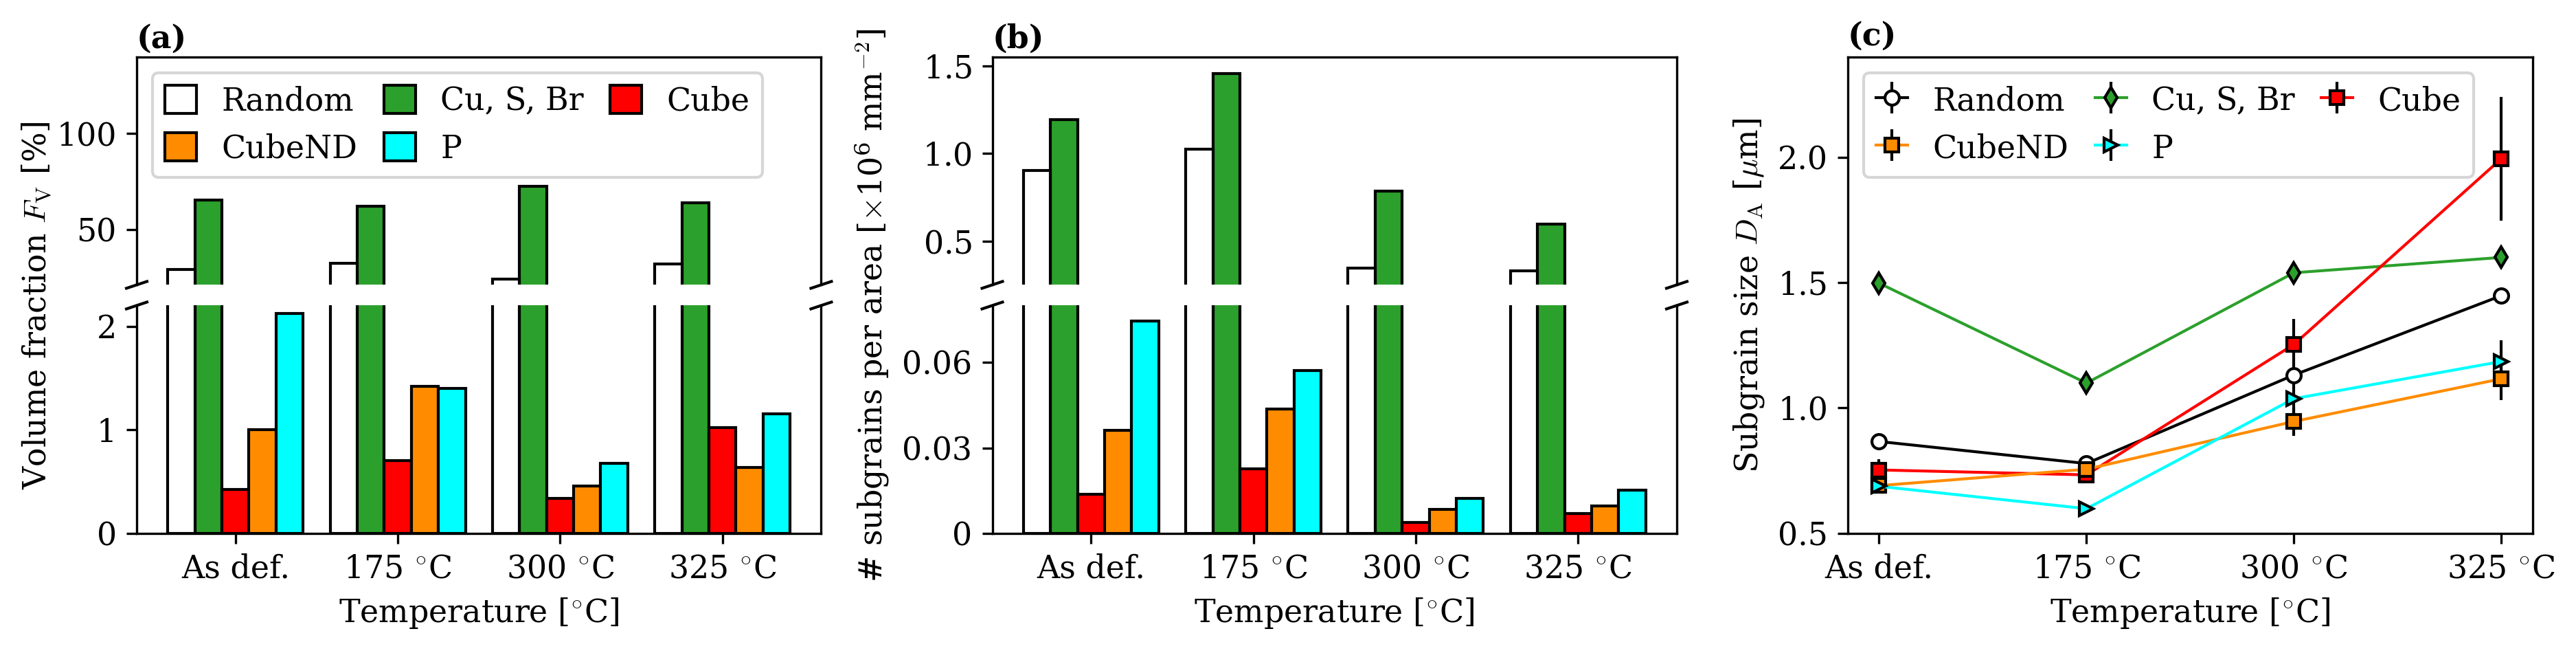

In [27]:
x = np.arange(len(grain_stats))
bar_width = 1 / 6
bar_kw = dict(width=bar_width, ec="k")

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 3))

# (a) Volume fraction
# -------------------
# Grains of deformed texture
h1 = ax0.bar(
    x - bar_width,
    100 * (grain_stats.fv_br + grain_stats.fv_cu + grain_stats.fv_s),
    label=comp_names[-1],
    color=comp_colors[comp_names[-1]],
    **bar_kw
)
handles = [h1,]
divider = make_axes_locatable(ax0)
ax01 = divider.new_vertical(size="100%", pad=0.1)
fig.add_axes(ax01)
ax01.bar(
    x - bar_width,
    100 * (grain_stats.fv_br + grain_stats.fv_cu + grain_stats.fv_s),
    label=comp_names[-1],
    color=comp_colors[comp_names[-1]],
    **bar_kw
)
# Remaining grains
for w, name in zip(
    [-2 * bar_width, 0, bar_width, 2 * bar_width],
    [comp_names[0],] + comp_names[4:7],
):
    c = comp_colors[name]
    h_i = ax0.bar(x + w, 100 * grain_stats[f"fv_{name.lower()}"], label=name, color=c, **bar_kw)
    ax01.bar(x + w, 100 * grain_stats[f"fv_{name.lower()}"], label=name, color=c, **bar_kw)
    handles.append(h_i)
# Broken axis
ax01.tick_params(bottom=False, labelbottom=False)
ax0.spines["top"].set_visible(False)
ax01.spines["bottom"].set_visible(False)
ax0.set_ylim(0, 2.2)
ax01.set_ylim(21, 140)
d = 0.015
kwargs = dict(transform=ax01.transAxes, color='k', clip_on=False)
ax01.plot((-d, d), (-d, d), **kwargs)
ax01.plot((1 - d, 1 + d), (-d, d), **kwargs)
kwargs.update(transform=ax0.transAxes)
ax0.plot((-d, d), (1 - d, 1 + d), **kwargs)
ax0.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)
# Labels
ax0.set_xticks(x)
ax0.set_xticklabels(titles)
ax0.set_xlabel("Temperature [$^{\circ}$C]")
ax0.set_ylabel("Volume fraction $F_{\mathrm{V}}$ [%]", y=1, labelpad=15)
ax01.text(0, 1.01, "(a)", transform=ax01.transAxes, **title_kw)
ax01.legend(
    handles=[handles[1], handles[3], handles[0], handles[4], handles[2]],
    labels=[comp_names[0], comp_names[5], comp_names[-1], comp_names[6], comp_names[4]],
    loc="upper left",
    ncol=3,
    handlelength=1,
    handleheight=1,
    columnspacing=0.83,
)

# (b) Number density of subgrains
# -------------------------------
# Subgrains of deformation texture
ax1.bar(
    x - bar_width,
    (grain_stats.n_grains_per_area_br + grain_stats.n_grains_per_area_cu + grain_stats.n_grains_per_area_s) * 1e6,
    label=comp_names[-1],
    color=comp_colors[comp_names[-1]],
    **bar_kw
)
divider = make_axes_locatable(ax1)
ax11 = divider.new_vertical(size="100%", pad=0.1)
fig.add_axes(ax11)
ax11.bar(
    x - bar_width,
    (grain_stats.n_grains_per_area_br + grain_stats.n_grains_per_area_cu + grain_stats.n_grains_per_area_s) * 1e6,
    label=comp_names[-1],
    color=comp_colors[comp_names[-1]],
    **bar_kw
)
# Remaining subgrains
for w, name in zip(
    [-2 * bar_width, 0, bar_width, 2 * bar_width],
    [comp_names[0],] + comp_names[4:7],
):
    c = comp_colors[name]
    ax1.bar(x + w, grain_stats[f"n_grains_per_area_{name.lower()}"] * 1e6, label=name, color=c, **bar_kw)
    ax11.bar(x + w, grain_stats[f"n_grains_per_area_{name.lower()}"] * 1e6, label=name, color=c, **bar_kw)
# Broken axis
ax11.tick_params(bottom=False, labelbottom=False)
ax1.spines["top"].set_visible(False)
ax11.spines["bottom"].set_visible(False)
ax1.set_ylim(0, 0.08e6)
ax11.set_ylim(0.25e6, 1.55e6)
d = 0.015
kwargs = dict(transform=ax11.transAxes, color='k', clip_on=False)
ax11.plot((-d, d), (-d, d), **kwargs)
ax11.plot((1 - d, 1 + d), (-d, d), **kwargs)
kwargs.update(transform=ax1.transAxes)
ax1.plot((-d, d), (1 - d, 1 + d), **kwargs)
ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)
# Labels
ax1.set_xticks(x)
ax1.set_xticklabels(titles)
ytick_labels = ["0", "0.03", "0.06"]
ax1.set_yticks([float(i) * 1e6 for i in ytick_labels])
ax1.set_yticklabels(ytick_labels)
ax1.set_xlabel("Temperature [$^{\circ}$C]")
ax11.text(0, 1.01, "(b)", transform=ax11.transAxes, **title_kw)
# Get exponent of y axis (must draw before getting it)
ax11.ticklabel_format(useMathText=True)
plt.draw()
exp = ax11.get_yaxis().get_offset_text().get_text()
ax11.get_yaxis().get_offset_text().set_visible(False)
ax1.set_ylabel("# subgrains per area [" + exp + r" mm$^{-2}$]", y=1)

# (c) Subgrain size (area weighted)
# ---------------------------------
# Subgrains of deformation texture
h1 = ax2.errorbar(
    x,
    grain_stats.ecd_mean_def,
    yerr=grain_stats.ecd_confint_def,
    label=comp_names[-1],
    marker=comp_markers[comp_names[-1]],
    color=comp_colors[comp_names[-1]],
    markerfacecolor=comp_colors[comp_names[-1]],
    markeredgecolor="k",
    ecolor="k",
)
handles3 = [h1,]
# Remaining grains
for w, name in zip(
    [-2 * bar_width, 0, bar_width, 2 * bar_width],
    [comp_names[0],] + comp_names[4:7],
):
    line_color = comp_colors[name]
    if name == "Random":
        line_color = "k"
    h_i = ax2.errorbar(
        x,
        grain_stats[f"ecd_mean_{name.lower()}"],
        yerr=grain_stats[f"ecd_confint_{name.lower()}"],
        label=name,
        marker=comp_markers[name],
        color=line_color,
        markerfacecolor=comp_colors[name],
        markeredgecolor="k",
        ecolor="k",
    )
    handles3.append(h_i)
ax2.set_xticks(x)
ax2.set_xticklabels(titles)
ax2.set_ylim(ymax=2.4)
ax2.set_xlabel("Temperature [$^{\circ}$C]")
ax2.set_ylabel(r"Subgrain size $D_{\mathrm{A}}$ [$\mu$m]")
ax2.text(0, 1.01, "(c)", transform=ax2.transAxes, **title_kw)
ax2.legend(
    handles=[handles3[1], handles3[3], handles3[0], handles3[4], handles3[2]],
    labels=[comp_names[0], comp_names[5], comp_names[-1], comp_names[6], comp_names[4]],
    loc="upper left",
    ncol=3,
    handlelength=1,
    handleheight=1,
    columnspacing=0.83,
)

fig.subplots_adjust(wspace=0.25)
fig.savefig(os.path.join(dir_article, "grain_stats/subgrain_stats.pdf"), **savefig_kw)

Volume fraction fractions

In [28]:
grain_stats["fv_p"] / grain_stats["fv_cubend"]

0s      2.125024
175c    0.984053
300c    1.471045
325c    1.817797
dtype: float64

In [29]:
grain_stats["fv_p"] / grain_stats["fv_cube"]

0s      5.019341
175c    1.996116
300c    1.986815
325c    1.124487
dtype: float64

Number of subgrains per area fractions

In [30]:
grain_stats["n_grains_per_area_p"] / grain_stats["n_grains_per_area_cubend"]

0s      2.067086
175c    1.310306
300c    1.469512
325c    1.574074
dtype: float64

In [31]:
grain_stats["n_grains_per_area_p"] / grain_stats["n_grains_per_area_cube"]

0s      5.477778
175c    2.526201
300c    3.301370
325c    2.207792
dtype: float64

Subgrain orientation spread (GOS) and subgrain average kernel average misorientation (GAM)

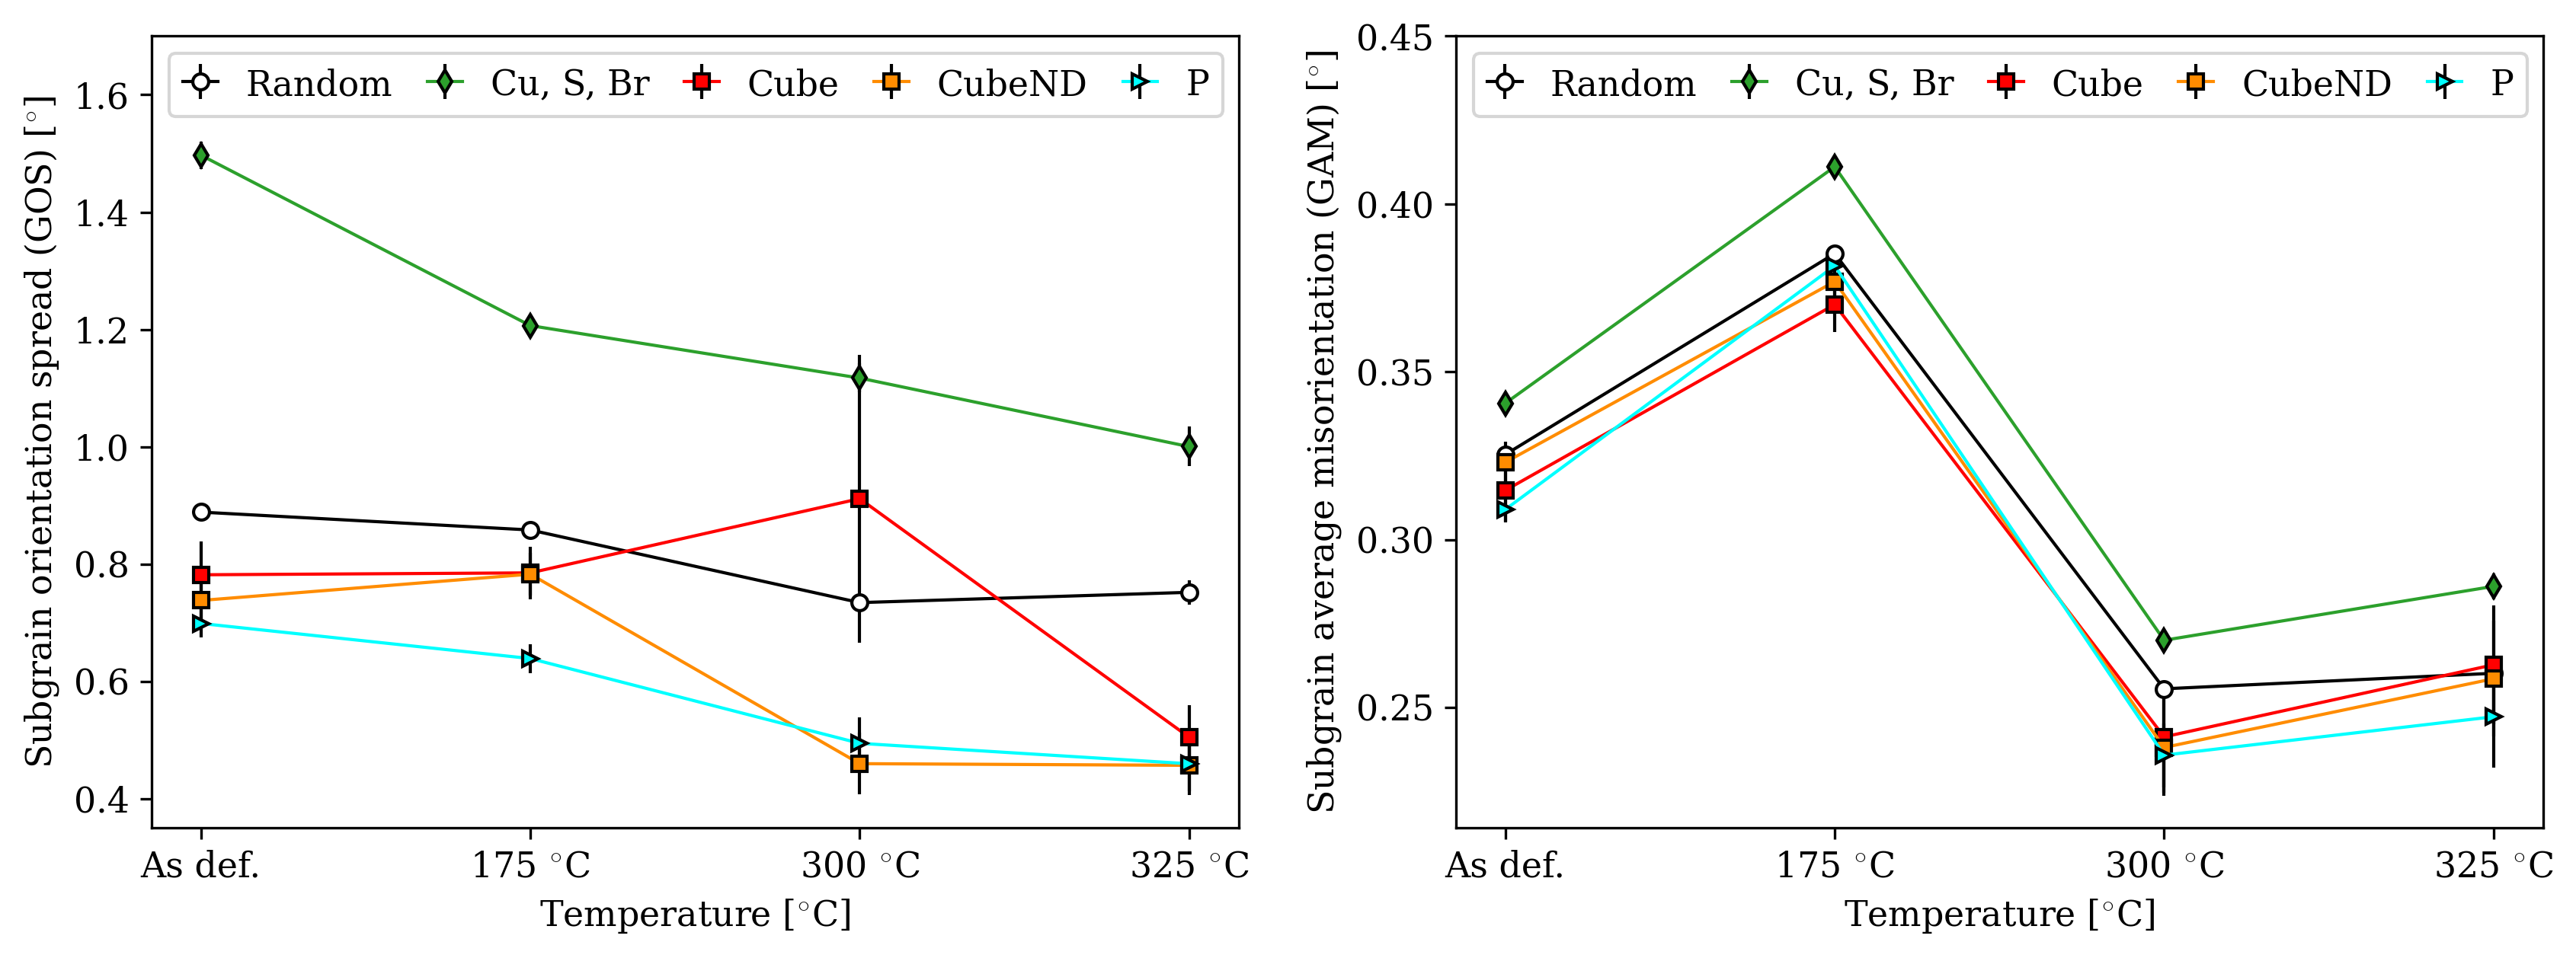

In [32]:
x = np.arange(len(grain_stats))

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(13.5, 4.5))

# (a) GOS
# -------
ax0.errorbar(
    x,
    np.rad2deg(np.mean([grain_stats.gos_mean_br, grain_stats.gos_mean_cu, grain_stats.gos_mean_s], axis=0)),
    yerr=np.rad2deg(np.mean([grain_stats.gos_confint_br, grain_stats.gos_confint_cu, grain_stats.gos_confint_s], axis=0)),
    label=comp_names[-1],
    color=comp_colors[comp_names[-1]],
    marker=comp_markers[comp_names[-1]],
    markerfacecolor=comp_colors[comp_names[-1]],
    markeredgecolor="k",
    ecolor="k",
)
for name in [comp_names[0],] + comp_names[4:7]:
    if name == "Random":
        line_color = "k"
    else:
        line_color = comp_colors[name]
    ax0.errorbar(
        x,
        np.rad2deg(grain_stats[f"gos_mean_{name.lower()}"]),
        yerr=np.rad2deg(grain_stats[f"gos_confint_{name.lower()}"]),
        label=name,
        color=line_color,
        marker=comp_markers[name],
        markerfacecolor=comp_colors[name],
        markeredgecolor="k",
        ecolor="k",
    )
ax0.set_xticks(x)
ax0.set_xticklabels(titles)
ax0.set_ylim(ymax=1.7)
ax0.set_xlabel("Temperature [$^{\circ}$C]")
ax0.set_ylabel("Subgrain orientation spread (GOS) [$^{\circ}$]")
ax0.legend()
handles, labels = ax0.get_legend_handles_labels()
order = [1, 0, 2, 3, 4]
ax0.legend(
    [handles[idx] for idx in order],
    [labels[idx] for idx in order],
    ncol=5,
    loc="upper left",
    columnspacing=1,
    handleheight=1,
    handlelength=1,
)

# (b) GAM
# -------
ax1.errorbar(
    x,
    np.rad2deg(np.mean([grain_stats.gam_mean_br, grain_stats.gam_mean_cu, grain_stats.gam_mean_s], axis=0)),
    yerr=np.rad2deg(np.mean([grain_stats.gam_confint_br, grain_stats.gam_confint_cu, grain_stats.gam_confint_s], axis=0)),
    label=comp_names[-1],
    color=comp_colors[comp_names[-1]],
    marker=comp_markers[comp_names[-1]],
    markerfacecolor=comp_colors[comp_names[-1]],
    markeredgecolor="k",
    ecolor="k",
)
for name in [comp_names[0],] + comp_names[4:7]:
    if name == "Random":
        line_color = "k"
    else:
        line_color = comp_colors[name]
    ax1.errorbar(
        x,
        np.rad2deg(grain_stats[f"gam_mean_{name.lower()}"]),
        yerr=np.rad2deg(grain_stats[f"gam_confint_{name.lower()}"]),
        label=name,
        color=line_color,
        marker=comp_markers[name],
        markerfacecolor=comp_colors[name],
        markeredgecolor="k",
        ecolor="k",
    )
ax1.set_xticks(x)
ax1.set_xticklabels(titles)
ax1.set_ylim(ymax=0.45)
ax1.set_xlabel("Temperature [$^{\circ}$C]")
ax1.set_ylabel("Subgrain average misorientation (GAM) [$^{\circ}$]")
ax1.legend()
handles, labels = ax1.get_legend_handles_labels()
order = [1, 0, 2, 3, 4]
ax1.legend(
    [handles[idx] for idx in order],
    [labels[idx] for idx in order],
    ncol=5,
    loc="upper left",
    columnspacing=1,
    handleheight=1,
    handlelength=1,
)

fig.subplots_adjust(wspace=0.2)

## Dispersoids at grain boundaries

Read data generated with `MTEX`, combining them into one dataset per temperature, thus loosing spatial information

In [290]:
gbs = {}
gbs_al = {}

# --- Dispersoid statistics per texture component
# Data frame columns
column_names = [
    "disp_per_length_mean", "disp_per_length_var", "disp_per_length_confint",
    "disp_size_mean", "disp_size_var", "disp_size_confint",
    "disp_size_per_length_mean", "disp_size_per_length_var", "disp_size_per_length_confint",
    "gb_length",
    "gb_csl3_length",
    "gb_csl7_length",
    "mori_mean", "mori_var", "mori_confint",
]
columns = []
for i in range(len(column_names)):
    for comp_name in comp_names_low[:-1]:
        columns.append(column_names[i] + "_" + comp_name)
comp_gb_stats = pd.DataFrame(
    np.zeros((len(identifier), len(columns))),
    index=identifier,
    columns=columns,
)

for sample in identifier:
    for j in range(3):
        # Read data from file
        gb_j = pd.read_csv(
            os.path.join(dir_data, f"prover/{sample}/{j + 1}/mtex/grain_boundaries.txt"),
            delimiter=","
        )
        
        # Create new data frame or add to existing
        if j == 0:
            gb_i = gb_j
        else:
            gb_i = pd.concat((gb_i, gb_j))

    # Relevant statistics
    gb_i["dispersoids_per_length"] = gb_i.n_dispersoids_close / gb_i.length
    gb_i["dispersoid_size_per_length"] = gb_i.dispersoids_close_size / gb_i.length
    gb_i["at_constituent_particle"] = gb_i.at_constituent_particle.astype(bool)
    gb_i["is_al"] = gb_i.is_al.astype(bool)

    gbs[sample] = gb_i
    gb_al_i = gb_i[gb_i.is_al]
    gbs_al[sample] = gb_al_i
    
    # Per texture component
    comp1 = gbs_al[sample].component1
    comp2 = gbs_al[sample].component2
    for k, name in zip(ideal_id, comp_names_low[:-1]):
        gb_al_k = gb_al_i[np.isin(comp1, k) | np.isin(comp2, k)]
        n_gb_al_k = gb_al_k.size
        n_gb_al_k_sqrt = np.sqrt(n_gb_al_k)

        # Number of dispersoids per boundary length
        comp_gb_stats.loc[sample][f"disp_per_length_mean_{name}"] = np.mean(gb_al_k.dispersoids_per_length)
        disp_per_length_var_k = np.var(gb_al_k.dispersoids_per_length)
        comp_gb_stats.loc[sample][f"disp_per_length_var_{name}"] = disp_per_length_var_k
        comp_gb_stats.loc[sample][f"disp_per_length_confint_{name}"] = 1.96 * np.sqrt(disp_per_length_var_k) / n_gb_al_k_sqrt

        # Average dispersoid size
        disp_size_k = gb_al_k.dispersoid_size_per_length * gb_al_k.length
        comp_gb_stats.loc[sample][f"disp_size_mean_{name}"] = np.mean(disp_size_k)
        disp_size_var_k = np.var(disp_size_k)
        comp_gb_stats.loc[sample][f"disp_size_var_{name}"] = disp_size_var_k
        comp_gb_stats.loc[sample][f"disp_size_confint_{name}"] = 1.96 * np.sqrt(disp_size_var_k) / n_gb_al_k_sqrt

        # Sum of dispersoid size per boundary
        comp_gb_stats.loc[sample][f"disp_size_per_length_mean_{name}"] = np.mean(gb_al_k.dispersoid_size_per_length)
        disp_size_per_length_var_k = np.var(gb_al_k.dispersoid_size_per_length)
        comp_gb_stats.loc[sample][f"disp_size_per_length_var_{name}"] = disp_size_per_length_var_k
        comp_gb_stats.loc[sample][f"disp_size_per_length_confint_{name}"] = 1.96 * np.sqrt(disp_size_per_length_var_k) / n_gb_al_k_sqrt

        # Number of special boundaries
        comp_gb_stats.loc[sample][f"gb_length_{name}"] = np.sum(gb_al_k.length)
        comp_gb_stats.loc[sample][f"gb_cls3_length_{name}"] = np.sum(gb_al_k[gb_al_k.is_csl3 == 1].length)
        comp_gb_stats.loc[sample][f"gb_cls7_length_{name}"] = np.sum(gb_al_k[gb_al_k.is_csl7 == 1].length)
        
        # Average misorientation angle
        comp_gb_stats.loc[sample][f"mori_mean_{name}"] = np.mean(gb_al_k.angle)
        mori_var_k = np.var(gb_al_k.angle)
        comp_gb_stats.loc[sample][f"mori_var_{name}"] = mori_var_k
        comp_gb_stats.loc[sample][f"mori_confint_{name}"] = 1.96 * np.sqrt(mori_var_k) / n_gb_al_k_sqrt

Misorientation angle distribution as a function of temperature and average misorientation per component as a function of temperature

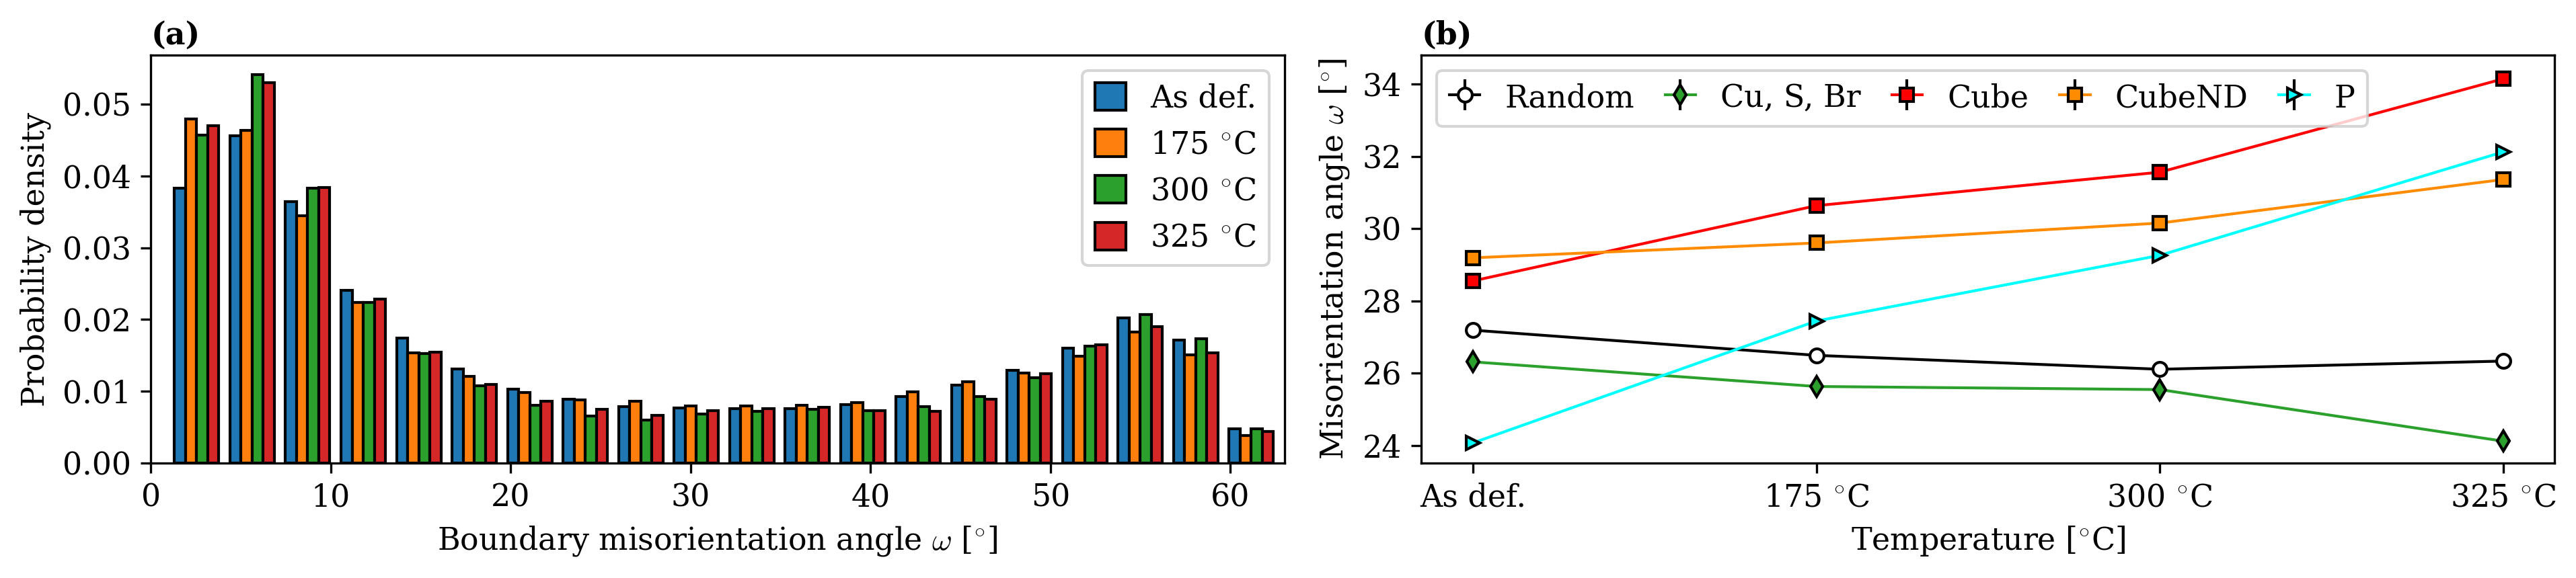

In [292]:
x = np.arange(len(grain_stats))

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(13, 3))

# --- (a) Histogram
ax0.hist([np.rad2deg(v.angle) for v in gbs_al.values()], label=titles, bins=20, density=True, ec="k")
ax0.set_xlabel("Boundary misorientation angle $\omega$ [$^{\circ}$]")
ax0.set_ylabel("Probability density")
ax0.set_xlim(0, 63)
ax0.legend(handleheight=1, handlelength=1)

# --- (b) Per component
ax1.errorbar(
    x,
    np.rad2deg(np.mean([comp_gb_stats.mori_mean_br, comp_gb_stats.mori_mean_cu, comp_gb_stats.mori_mean_s], axis=0)),
    yerr=np.rad2deg(np.mean([comp_gb_stats.mori_confint_br, comp_gb_stats.mori_confint_cu, comp_gb_stats.mori_confint_s], axis=0)),
    label=comp_names[-1],
    color=comp_colors[comp_names[-1]],
    marker=comp_markers[comp_names[-1]],
    markerfacecolor=comp_colors[comp_names[-1]],
    markeredgecolor="k",
    ecolor="k",
)
for name in [comp_names[0],] + comp_names[4:7]:
    if name == "Random":
        line_color = "k"
    else:
        line_color = comp_colors[name]
    ax1.errorbar(
        x,
        np.rad2deg(comp_gb_stats[f"mori_mean_{name.lower()}"]),
        yerr=np.rad2deg(comp_gb_stats[f"mori_confint_{name.lower()}"]),
        label=name,
        color=line_color,
        marker=comp_markers[name],
        markerfacecolor=comp_colors[name],
        markeredgecolor="k",
        ecolor="k",
    )
ax1.set_xticks(x)
ax1.set_xticklabels(titles)
ax1.set_xlabel("Temperature [$^{\circ}$C]")
ax1.set_ylabel("Misorientation angle $\omega$ [$^{\circ}$]")
ax1.legend()
handles, labels = ax1.get_legend_handles_labels()
order = [1, 0, 2, 3, 4]
ax1.legend(
    [handles[idx] for idx in order],
    [labels[idx] for idx in order],
    ncol=5,
    loc="upper left",
    columnspacing=1,
    handleheight=1,
    handlelength=1,
)

# Labels
ax0.text(0, 1.01, "(a)", transform=ax0.transAxes, **title_kw)
ax1.text(0, 1.01, "(b)", transform=ax1.transAxes, **title_kw)

fig.tight_layout()
fig.savefig(os.path.join(dir_article, "misorientation_angles/mori_angle_hist_per_comp.pdf"), **savefig_kw)

Cumulative distribution of dispersoids' distance to a boundary

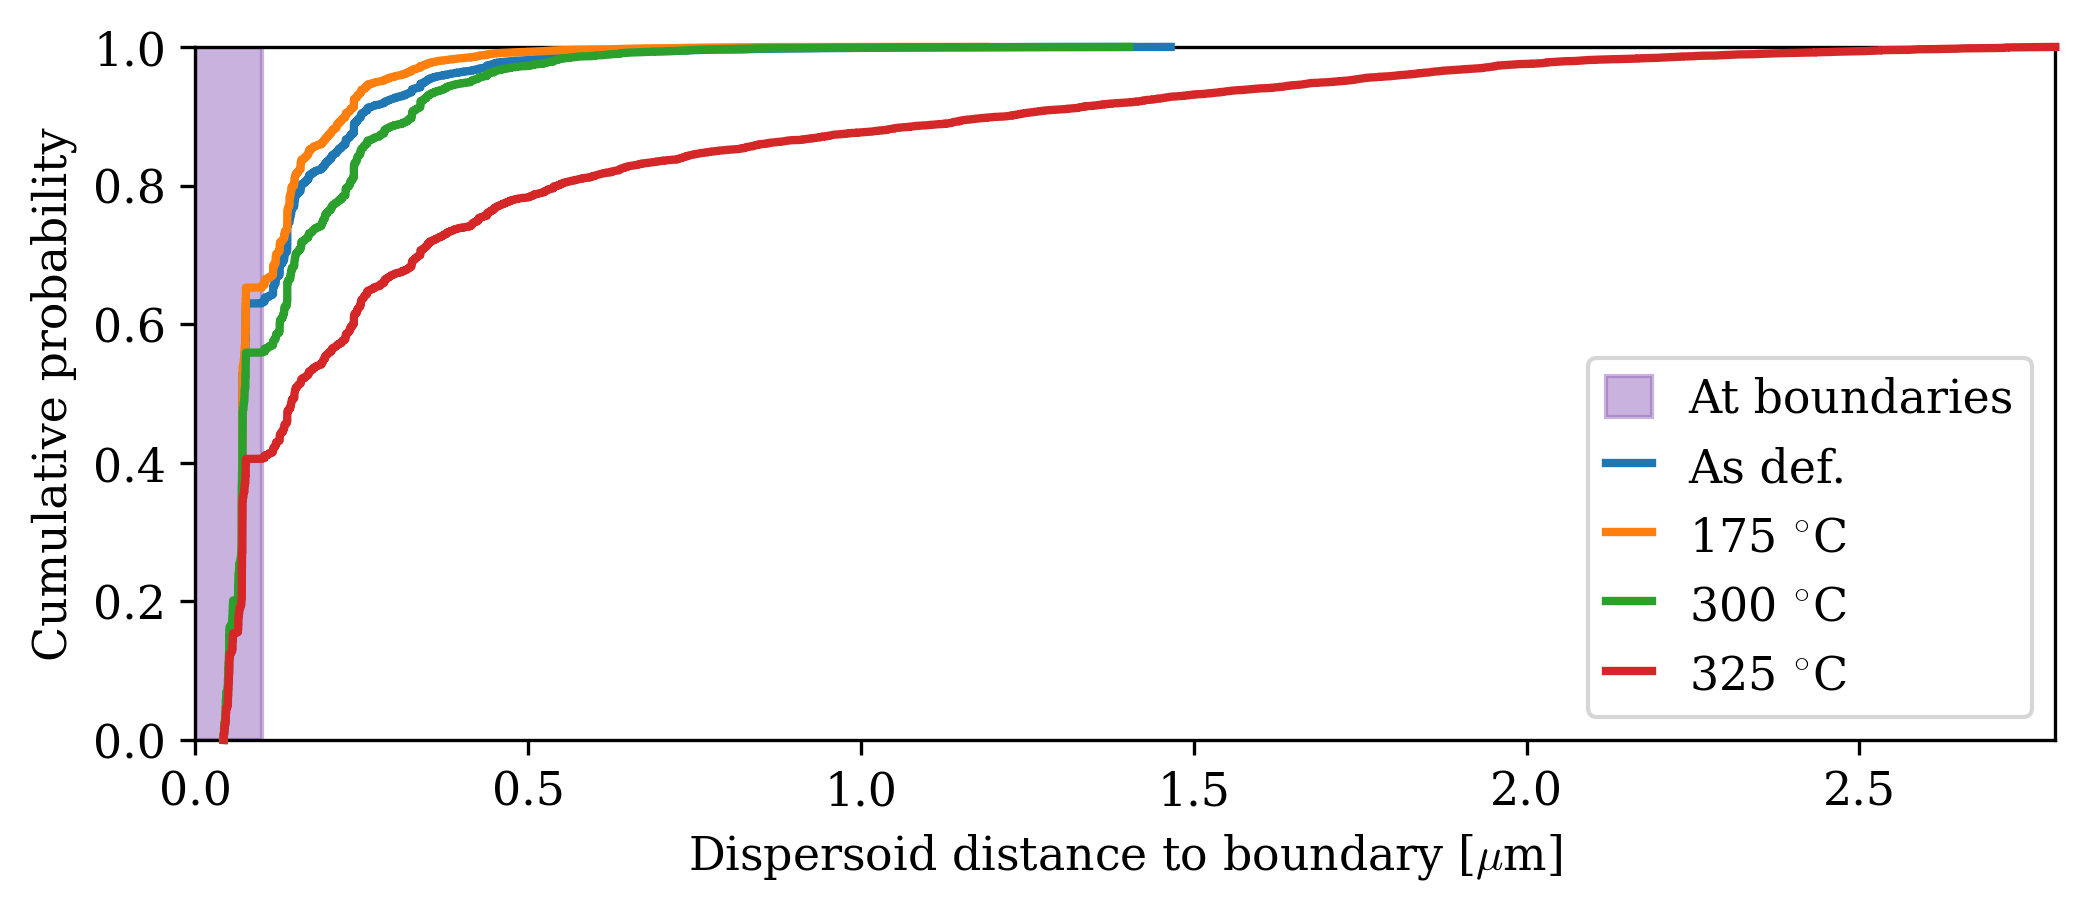

In [293]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.set_xlabel(r"Dispersoid distance to boundary [$\mu$m]")
ax.set_ylabel("Cumulative probability")
ax.axvspan(0, 0.1, color="C4", alpha=0.5, zorder=0, label="At boundaries")
ax.set_ylim(0, 1)
x_max = 0
for i, sample in enumerate(identifier):
    x_max = max([dist_to_gb_sorted[sample].max(), x_max])
    ax.plot(dist_to_gb_sorted[sample], dist_to_gb_cdf[sample], lw=2, clip_on=False, zorder=5, label=titles[i])
ax.legend(loc="lower right", handleheight=1, handlelength=1)
ax.set_xlim(0, x_max)
fig.savefig(os.path.join(dir_article, "dispersoids_at_gb/dispersoid_distance_to_gb.pdf"), **savefig_kw)

Calculate
* Number of dispersoids per boundary length as a function of boundary misorientation angle $\omega$, per temperature
* Dispersoid size per boundary length as a function of boundary misorientation angle

In [294]:
tinv = lambda confint, dof: abs(scs.t.ppf(confint / 2, dof))

# Number of dispersoids
disp_per_angle_length = {}
disp_per_angle_length_confint = {}
disp_per_angle_res = {}
disp_per_angle_ts = {}

# Dispersoid size
disp_size_per_angle_length = {}
disp_size_per_angle_length_confint = {}
disp_size_per_angle_res = {}
disp_size_per_angle_ts = {}

# Get min/max of angles in all datasets
angle_min = 63
angle_max = 0
for sample in identifier:
    angle_i = gbs_al[sample].angle
    angle_i_min, angle_i_max = angle_i.min(), angle_i.max()
    if angle_i_min < angle_min:
        angle_min = angle_i_min
    if angle_i_max > angle_max:
        angle_max = angle_i_max

n_bins = 30
bin_edges = np.linspace(angle_min, angle_max, n_bins + 1)
bin_means = np.convolve(bin_edges, np.ones(2), mode="valid") / 2
bin_means_deg = np.rad2deg(bin_means)

for sample in identifier:
    angle_i = gbs_al[sample].angle

    # --- Number of dispersoids
    # Mean
    disp_per_angle_length_i, _, bin_num_i = scs.binned_statistic(
        x=angle_i,
        values=gbs_al[sample].dispersoids_per_length,
        statistic="mean",
        bins=bin_edges
    )
    # Standard deviation
    disp_per_angle_length_std_i = scs.binned_statistic(
        x=angle_i,
        values=gbs_al[sample].dispersoids_per_length,
        statistic="std",
        bins=bin_edges
    )[0]
    # 95% confidence interval
    n_gbs_i = np.unique(bin_num_i, return_counts=True)[1]
    disp_per_angle_length_confint_i = 1.96 * disp_per_angle_length_std_i / np.sqrt(n_gbs_i)
    # Linear regression with 95% confidence interval for intercept and slope
    res_i = scs.linregress(bin_means, disp_per_angle_length_i)
    ts_i = tinv(1 - 0.95, n_bins - 2)
    print(f"Number of dispersoids: slope (95%): {res_i.slope:.6f} +/- {ts_i * res_i.stderr:.6f}")
    # Save for later
    disp_per_angle_length[sample] = disp_per_angle_length_i
    disp_per_angle_length_confint[sample] = disp_per_angle_length_confint_i
    disp_per_angle_res[sample] = res_i
    disp_per_angle_ts[sample] = ts_i
    
    # --- Dispersoid size
    # Mean
    disp_size_per_angle_length_i, _, bin_num_size_i = scs.binned_statistic(
        x=angle_i,
        values=gbs_al[sample].dispersoid_size_per_length,
        statistic="mean",
        bins=bin_edges
    )
    # Standard deviation
    disp_size_per_angle_length_std_i = scs.binned_statistic(
        x=angle_i,
        values=gbs_al[sample].dispersoid_size_per_length,
        statistic="std",
        bins=bin_edges
    )[0]
    # 95% confidence interval
    n_gbs_size_i = np.unique(bin_num_size_i, return_counts=True)[1]
    disp_size_per_angle_length_confint_i = 1.96 * disp_size_per_angle_length_std_i / np.sqrt(n_gbs_size_i)
    # Linear regression with 95% confidence interval for intercept and slope 
    res_size_i = scs.linregress(bin_means, disp_size_per_angle_length_i)
    ts_size_i = tinv(1 - 0.95, n_bins - 2)
    print(f"Dispersoid size:       slope (95%): {res_size_i.slope:.6f} +/- {ts_size_i * res_size_i.stderr:.6f}\n")
    # Save for later
    disp_size_per_angle_length[sample] = disp_size_per_angle_length_i
    disp_size_per_angle_length_confint[sample] = disp_size_per_angle_length_confint_i
    disp_size_per_angle_res[sample] = res_size_i
    disp_size_per_angle_ts[sample] = ts_size_i

Number of dispersoids: slope (95%): -0.063973 +/- 0.033577
Dispersoid size:       slope (95%): -0.003290 +/- 0.001881

Number of dispersoids: slope (95%): -0.041592 +/- 0.020896
Dispersoid size:       slope (95%): 0.000100 +/- 0.001797

Number of dispersoids: slope (95%): -0.001563 +/- 0.041710
Dispersoid size:       slope (95%): 0.005017 +/- 0.004852

Number of dispersoids: slope (95%): 0.065225 +/- 0.052242
Dispersoid size:       slope (95%): 0.011646 +/- 0.005560



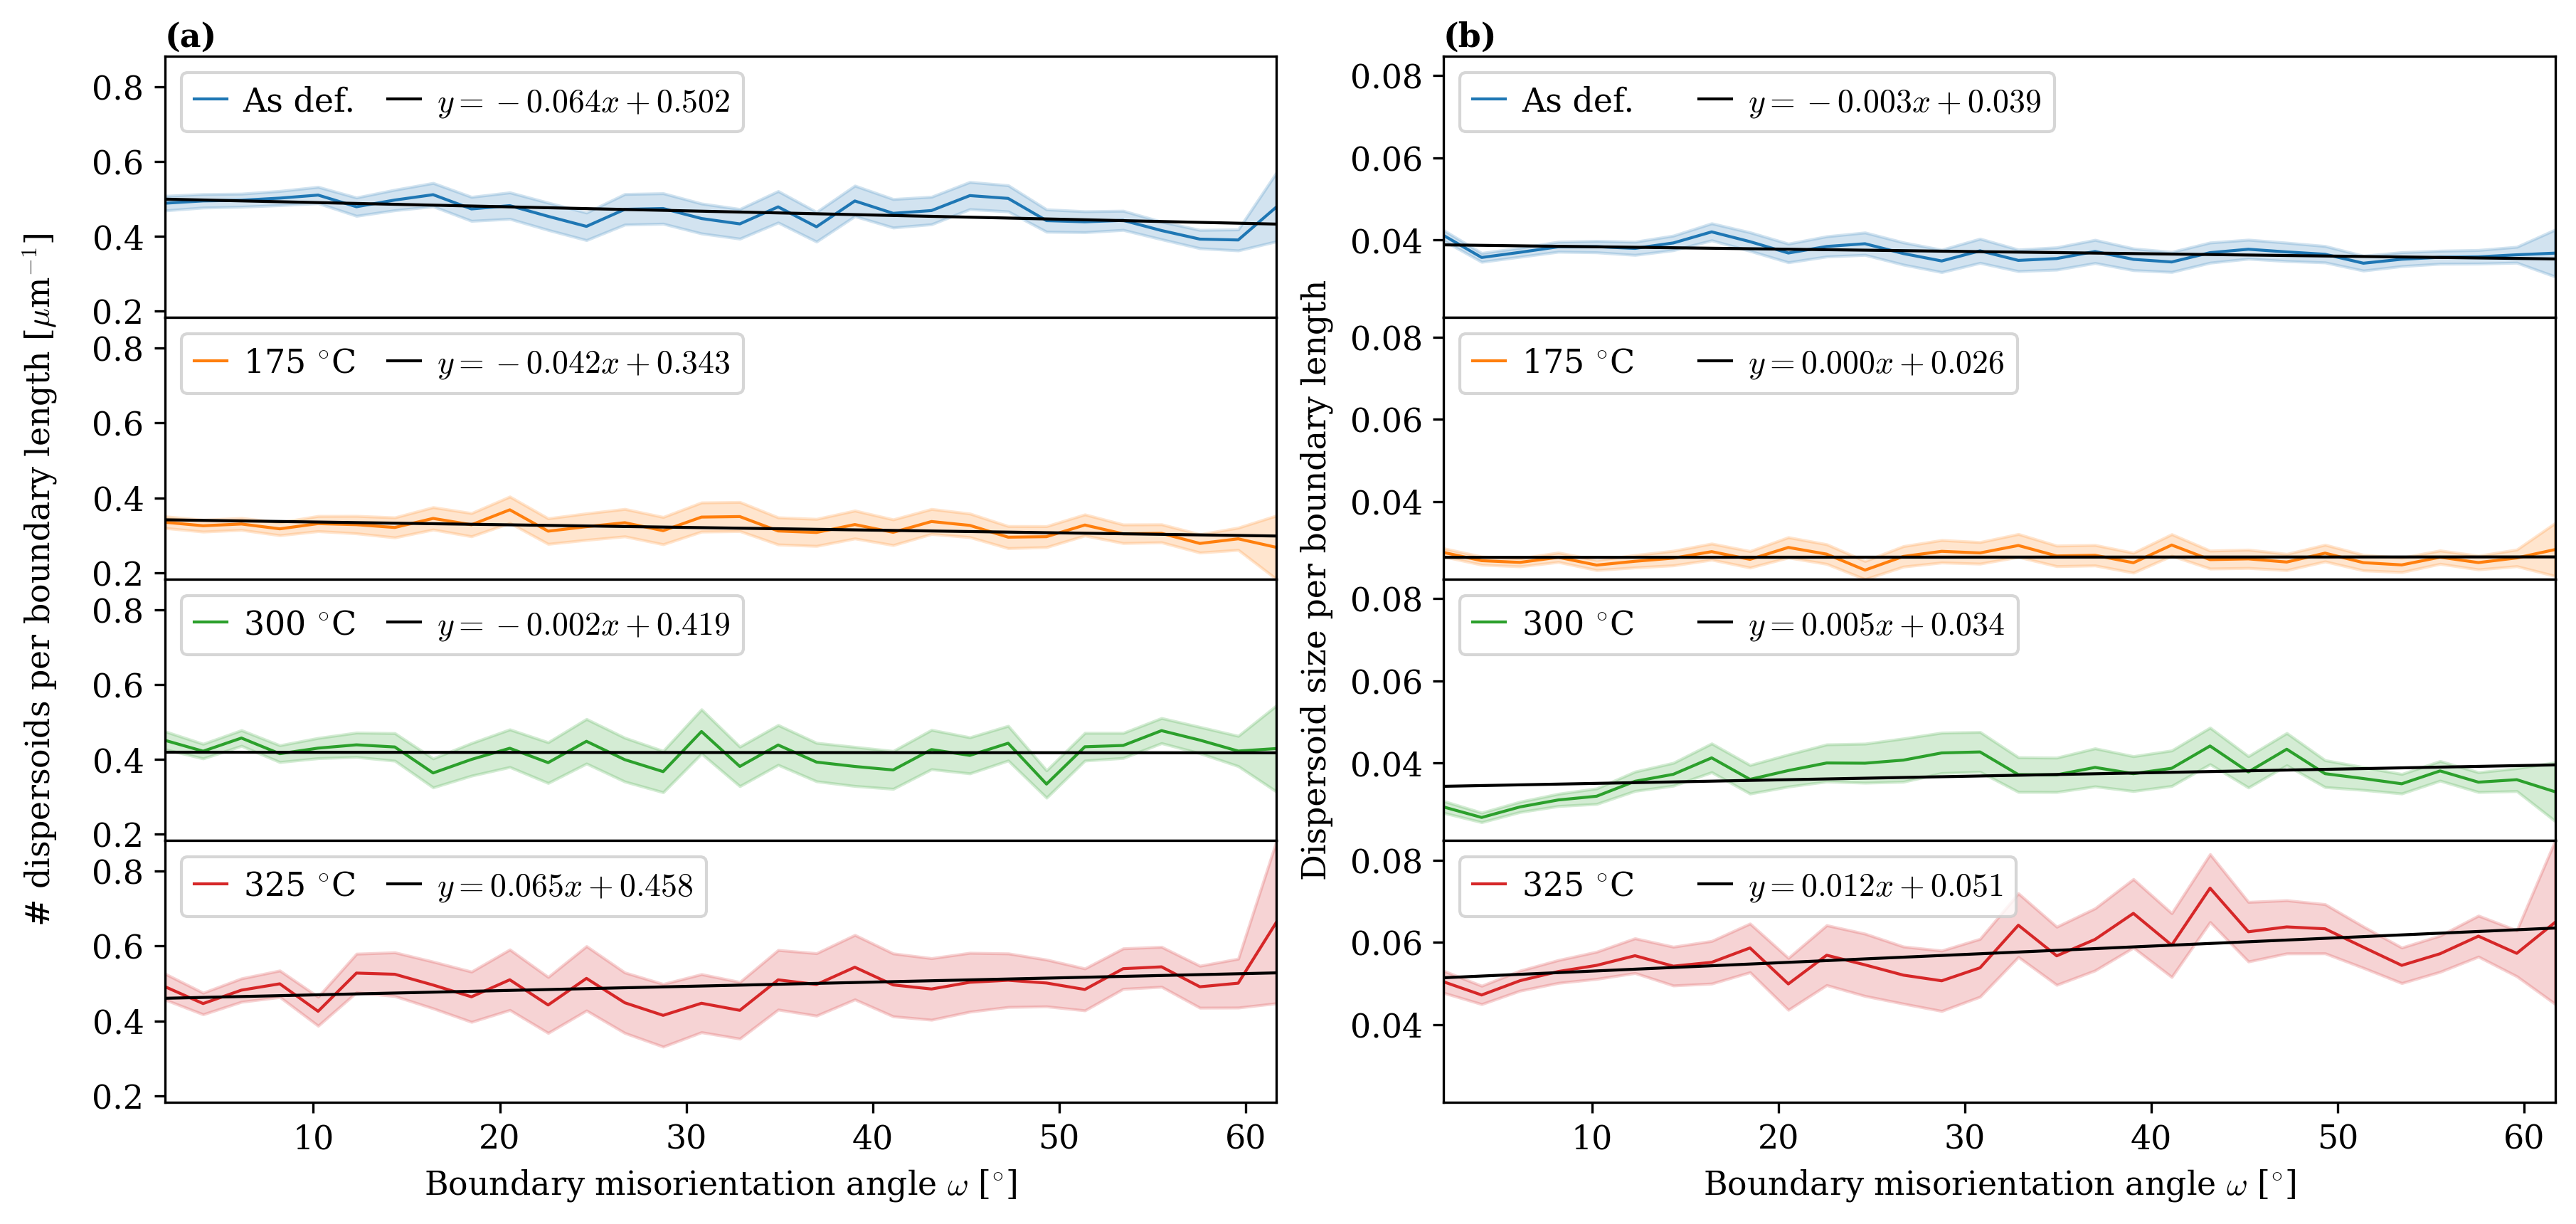

In [295]:
y1_min, y1_max = (1, 0)
y2_min, y2_max = (1, 0)

fig_ratio = 0.7
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(fig_ratio * 16, fig_ratio * 7), sharex=True)
fig.subplots_adjust(hspace=0, wspace=0.15, left=0, bottom=0, right=1, top=1)
for i, sample in enumerate(identifier):
    angle_i = gbs_al[sample].angle

    # --- (a) Dispersoids per boundary length
    disp_per_angle_length_i = disp_per_angle_length[sample]
    disp_per_angle_length_confint_i = disp_per_angle_length_confint[sample]
    res_i = disp_per_angle_res[sample]
    ts_i = disp_per_angle_ts[sample]
    # Plot data
    ax[i, 0].fill_between(
        bin_means_deg,
        disp_per_angle_length_i - disp_per_angle_length_confint_i,
        disp_per_angle_length_i + disp_per_angle_length_confint_i,
        alpha=0.2,
        color=f"C{i}"
    )
    ax[i, 0].plot(bin_means_deg, disp_per_angle_length_i, f"C{i}-", label=titles[i])
    # Plot linear regression line
    if res_i.slope < 0:
        sign = "-"
    else:
        sign = "+"
    ax[i, 0].plot(
        bin_means_deg,
        res_i.intercept + res_i.slope * bin_means,
        "k-",
        label=fr"$y = {res_i.slope:.3f}x + {res_i.intercept:.3f}$",
    )
    # Legend
    ax[i, 0].legend(loc="upper left", ncol=2, handlelength=1, handletextpad=0.5, columnspacing=1)
    # Axes limits
    ax[i, 0].set_xlim(bin_means_deg.min(), bin_means_deg.max())
    y1_i_min = (disp_per_angle_length_i - disp_per_angle_length_confint_i).min()
    y1_i_max = (disp_per_angle_length_i + disp_per_angle_length_confint_i).max()
    if y1_i_min < y1_min:
        y1_min = y1_i_min
    if y1_i_max > y1_max:
        y1_max = y1_i_max

    # --- (b) Dispersoid size per boundary length
    disp_size_per_angle_length_i = disp_size_per_angle_length[sample]
    disp_size_per_angle_length_confint_i = disp_size_per_angle_length_confint[sample]
    res_i = disp_size_per_angle_res[sample]
    ts_i = disp_size_per_angle_ts[sample]
    # Plot data
    ax[i, 1].fill_between(
        bin_means_deg,
        disp_size_per_angle_length_i - disp_size_per_angle_length_confint_i,
        disp_size_per_angle_length_i + disp_size_per_angle_length_confint_i,
        alpha=0.2,
        color=f"C{i}"
    )
    ax[i, 1].plot(bin_means_deg, disp_size_per_angle_length_i, f"C{i}-", label=titles[i])
    # Plot linear regression line
    if res_i.slope < 0:
        sign = "-"
    else:
        sign = "+"
    ax[i, 1].plot(
        bin_means_deg,
        res_i.intercept + res_i.slope * bin_means,
        "k-",
        label=fr"$y = {res_i.slope:.3f}x + {res_i.intercept:.3f}$",
    )
    # Legend
    ax[i, 1].legend(loc="upper left", ncol=2, handlelength=1, handletextpad=0.5)
    # Axes limits
    ax[i, 1].set_xlim(bin_means_deg.min(), bin_means_deg.max())
    y2_i_min = (disp_size_per_angle_length_i - disp_size_per_angle_length_confint_i).min()
    y2_i_max = (disp_size_per_angle_length_i + disp_size_per_angle_length_confint_i).max()
    if y2_i_min < y2_min:
        y2_min = y2_i_min
    if y2_i_max > y2_max:
        y2_max = y2_i_max
    
for a in ax[:, 0]:
    a.set_ylim(y1_min, y1_max)
for a in ax[:, 1]:
    a.set_ylim(y2_min, y2_max)
ax[3, 0].set_xlabel(r"Boundary misorientation angle $\omega$ [$^{\circ}$]")
ax[3, 1].set_xlabel(r"Boundary misorientation angle $\omega$ [$^{\circ}$]")
fig.text(-0.06, 0.5, r"# dispersoids per boundary length [$\mu$m$^{-1}$]", rotation=90, va="center")
fig.text(0.475, 0.5, r"Dispersoid size per boundary length", rotation=90, va="center")
fig.text(0, 1.01, "(a)", transform=ax[0, 0].transAxes, **title_kw)
fig.text(0, 1.01, "(b)", transform=ax[0, 1].transAxes, **title_kw)

fig.savefig(os.path.join(dir_article, "dispersoids_at_gb/dispersoids_at_gb_per_angle.pdf"), **savefig_kw);

Plot number of dispersoids and dispersoids size per texture component boundary

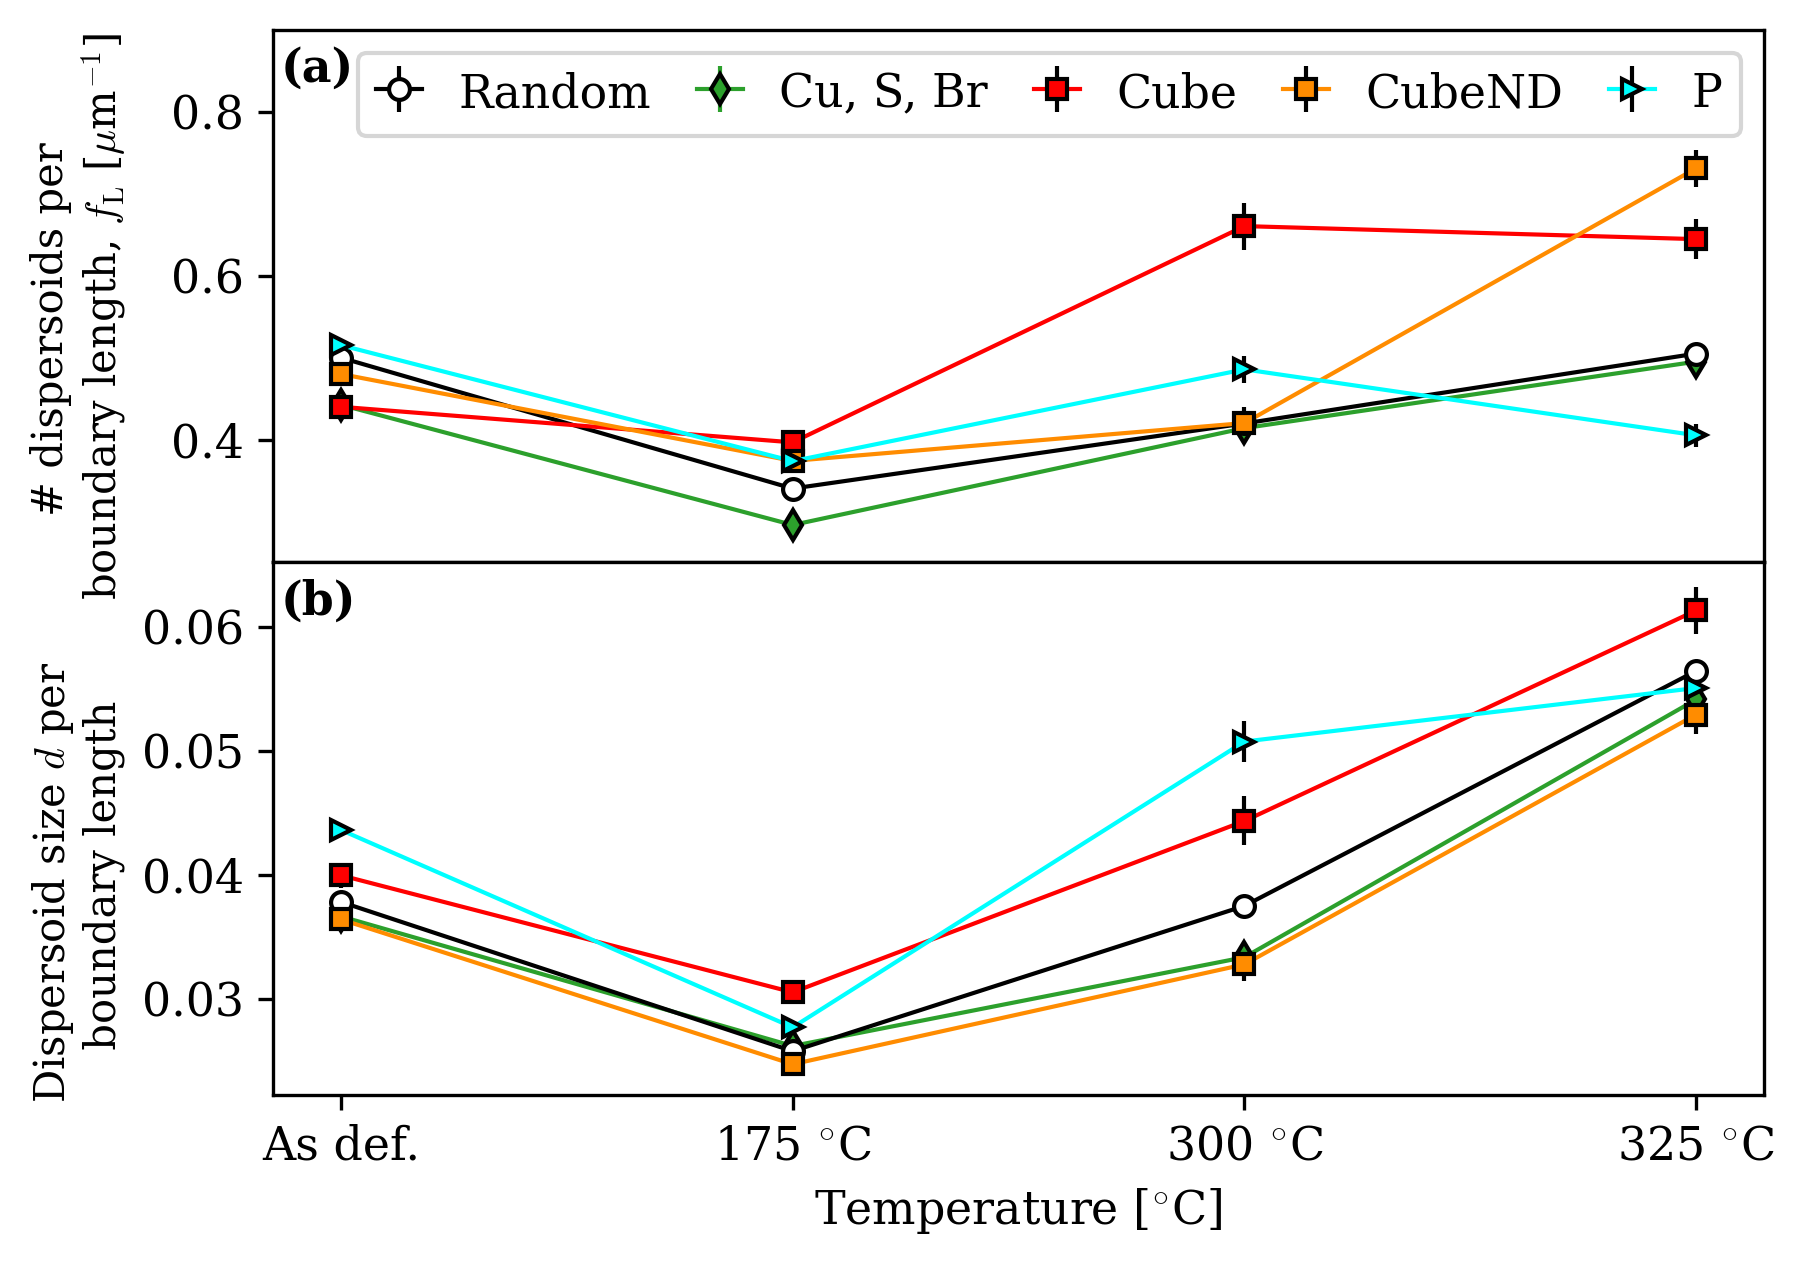

In [296]:
x = np.arange(len(grain_stats))

fig_ratio = 0.71
figsize = tuple(fig_ratio * np.array((7, 5)))
fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=figsize, sharex=True)
fig.subplots_adjust(hspace=0, wspace=0.15, left=0, bottom=0, right=1, top=1)

# --- (a) Dispersoids per boundary length
ax0.errorbar(
    x,
    np.mean(
        [
            comp_gb_stats.disp_per_length_mean_br,
            comp_gb_stats.disp_per_length_mean_cu,
            comp_gb_stats.disp_per_length_mean_s
        ],
        axis=0
    ),
    yerr=np.mean(
        [
            comp_gb_stats.disp_per_length_confint_br,
            comp_gb_stats.disp_per_length_confint_cu,
            comp_gb_stats.disp_per_length_confint_s
        ],
        axis=0
    ),
    label=comp_names[-1],
    marker=comp_markers[comp_names[-1]],
    color=comp_colors[comp_names[-1]],
    markerfacecolor=comp_colors[comp_names[-1]],
    markeredgecolor="k",
)
for name in [comp_names[0],] + comp_names[4:7]:
    if name == "Random":
        line_color = "k"
    else:
        line_color = comp_colors[name]
    ax0.errorbar(
        x,
        comp_gb_stats[f"disp_per_length_mean_{name.lower()}"],
        yerr=comp_gb_stats[f"disp_per_length_confint_{name.lower()}"],
        label=name,
        marker=comp_markers[name],
        color=line_color,
        markerfacecolor=comp_colors[name],
        markeredgecolor="k",
        ecolor="k",
    )
ax0.set_xticks(x)
ax0.set_ylabel(
    "# dispersoids per \n boundary length, $f_{\mathrm{L}}$ [$\mu$m$^{-1}$]",
    fontsize=plt.rcParams["font.size"] - 1,
    y=0.45,
    labelpad=10
)
ax0.legend()
handles, labels = ax0.get_legend_handles_labels()
order = [1, 0, 2, 3, 4]
ax0.legend(
    [handles[idx] for idx in order],
    [labels[idx] for idx in order],
    ncol=5,
    loc="upper right",
    columnspacing=1,
    handleheight=1,
    handlelength=1,
)

# --- (b) Dispersoid size per boundary length
ax1.errorbar(
    x,
    np.mean(
        [
            comp_gb_stats.disp_size_per_length_mean_br,
            comp_gb_stats.disp_size_per_length_mean_cu,
            comp_gb_stats.disp_size_per_length_mean_s
        ],
        axis=0
    ),
    yerr=np.mean(
        [
            comp_gb_stats.disp_size_per_length_confint_br,
            comp_gb_stats.disp_size_per_length_confint_cu,
            comp_gb_stats.disp_size_per_length_confint_s
        ],
        axis=0
    ),
    label=comp_names[-1],
    marker=comp_markers[comp_names[-1]],
    color=comp_colors[comp_names[-1]],
    markerfacecolor=comp_colors[comp_names[-1]],
    markeredgecolor="k",
)
for name in [comp_names[0],] + comp_names[4:7]:
    if name == "Random":
        line_color = "k"
    else:
        line_color = comp_colors[name]
    ax1.errorbar(
        x,
        comp_gb_stats[f"disp_size_per_length_mean_{name.lower()}"],
        yerr=comp_gb_stats[f"disp_size_per_length_confint_{name.lower()}"],
        label=name,
        marker=comp_markers[name],
        color=line_color,
        markerfacecolor=comp_colors[name],
        markeredgecolor="k",
        ecolor="k",
    )
ax1.set_xticks(x)
ax1.set_xticklabels(titles)
ax1.set_xlabel("Temperature [$^{\circ}$C]")
ax1.set_ylabel(
    "Dispersoid size $d$ per \n boundary length",
    fontsize=plt.rcParams["font.size"] - 1,
    y=0.4
)

# Labels
title_kw2 = title_kw.copy()
title_kw2["va"] = "top"
ax0.text(0.005, 0.97, "(a)", transform=ax0.transAxes, **title_kw2)
ax1.text(0.005, 0.97, "(b)", transform=ax1.transAxes, **title_kw2);

# Axes limits
ax0.set_ylim(0.25, 0.9)

fig.savefig(os.path.join(dir_article, "dispersoids_at_gb/dispersoids_at_gb_per_comp.pdf"), **savefig_kw)

Plot dispersoid size per boundary length per texture component

## Smith-Zener drag $P_{\mathrm{sb}}^{'}$

In [297]:
# Data frame columns
column_names = ["p_sz_prop", "p_delta"]
columns = []
for i in range(len(column_names)):
    for comp_name in comp_names_low[:-1]:
        columns.append(column_names[i] + "_" + comp_name)
pinning_stats = pd.DataFrame(
    np.zeros((len(identifier), len(columns))),
    index=identifier,
    columns=columns,
)

for name in comp_names_low[:-1]:
    f_L_i = comp_gb_stats[f"disp_per_length_mean_{name}"]
    f_L_delta_i = comp_gb_stats[f"disp_per_length_confint_{name}"]

    D_A_i = grain_stats[f"ecd_mean_{name}"]
    D_A_delta_i = grain_stats[f"ecd_confint_{name}"]
    
    d_average_i = comp_gb_stats[f"disp_size_mean_{name}"]
    d_average_delta_i = comp_gb_stats[f"disp_size_confint_{name}"]
    
    pinning_stats[f"p_sz_prop_{name}"] = f_L_i * D_A_i / d_average_i
    pinning_stats[f"p_delta_{name}"] = pinning_stats[f"p_sz_prop_{name}"] * np.sqrt(
        (f_L_delta_i / f_L_i) ** 2
        + (D_A_delta_i / D_A_i) ** 2
        + (-d_average_delta_i / d_average_i) ** 2
    )

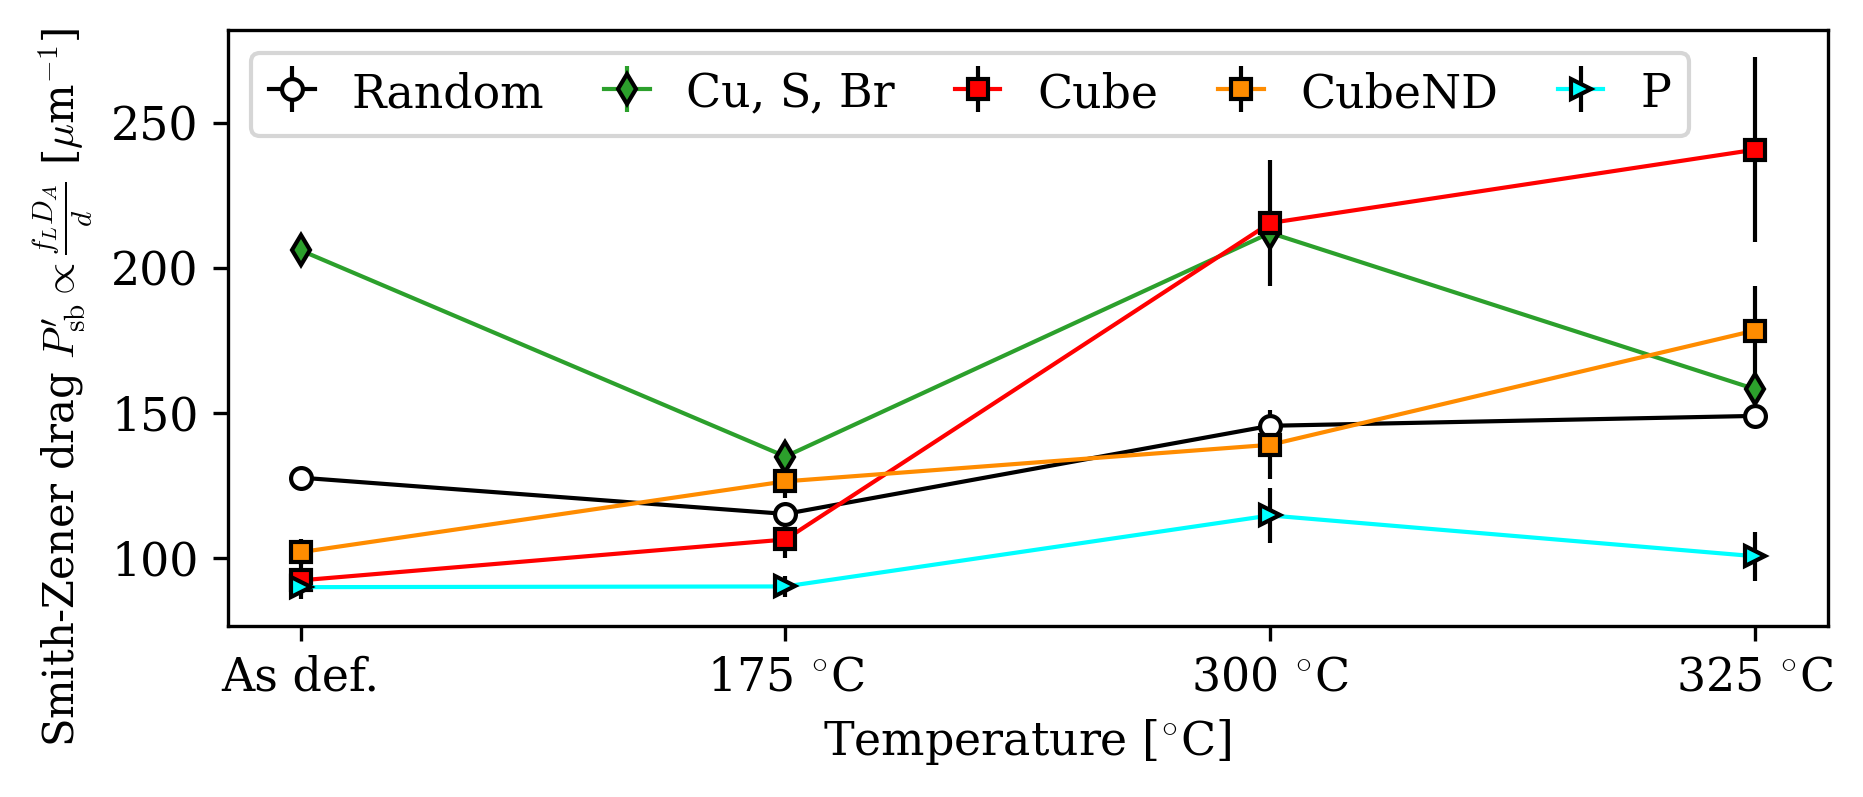

In [298]:
x = np.arange(len(grain_stats))

fig_ratio = 0.86
fig, ax = plt.subplots(figsize=(fig_ratio * 8, fig_ratio * 3))
ax.errorbar(
    x,
    np.mean([pinning_stats.p_sz_prop_br, pinning_stats.p_sz_prop_cu, pinning_stats.p_sz_prop_s], axis=0),
    yerr=np.mean([pinning_stats.p_delta_br, pinning_stats.p_delta_cu, pinning_stats.p_delta_s], axis=0),
    label=comp_names[-1],
    marker=comp_markers[comp_names[-1]],
    color=comp_colors[comp_names[-1]],
    markerfacecolor=comp_colors[comp_names[-1]],
    markeredgecolor="k",
)
for name in [comp_names[0],] + comp_names[4:7]:
    if name == "Random":
        line_color = "k"
    else:
        line_color = comp_colors[name]
    ax.errorbar(
        x,
        pinning_stats[f"p_sz_prop_{name.lower()}"],
        yerr=pinning_stats[f"p_delta_{name.lower()}"],
        label=name,
        marker=comp_markers[name],
        color=line_color,
        markerfacecolor=comp_colors[name],
        markeredgecolor="k",
        ecolor="k",
    )
ax.set_xticks(x)
ax.set_xticklabels(titles)
ax.set_xlabel("Temperature [$^{\circ}$C]")
ax.set_ylabel(
    r"Smith-Zener drag $P_{\mathrm{sb}}' \propto \frac{f_L D_A}{d}$ [$\mu$m$^{-1}$]",
    y=0.4,
    fontsize=plt.rcParams["font.size"] - 1
)

# Legend (reorder)
ax.legend()
handles, labels = ax.get_legend_handles_labels()
order = [1, 0, 2, 3, 4]
ax.legend(
    [handles[idx] for idx in order],
    [labels[idx] for idx in order],
    ncol=5,
    loc="upper left",
    columnspacing=1.3,
    handleheight=1,
    handlelength=1,
)

fig.savefig(os.path.join(dir_article, "smith_zener_drag/smith_zener_drag.pdf"), **savefig_kw)

### Interparticle spacing $N_{\mathrm{s}}^{-0.5}$

In [299]:
interparticle_spacing = particle_stats["nn_distance_grid_d"]
interparticle_spacing

0s      0.608402
175c    0.642684
300c    0.628736
325c    0.558710
Name: nn_distance_grid_d, dtype: float64

In [300]:
ecd_mean_all = grain_stats[[
    "ecd_mean_br",
    "ecd_mean_cu",
    "ecd_mean_s",
    "ecd_mean_cube",
    "ecd_mean_cubend",
    "ecd_mean_p",
    "ecd_mean_random"
]].mean(axis=1)
ecd_mean_all

0s      1.091782
175c    0.866769
300c    1.268916
325c    1.477489
dtype: float64

In [301]:
100 * interparticle_spacing / ecd_mean_all

0s      55.725583
175c    74.147117
300c    49.549071
325c    37.814860
dtype: float64

## Subgrains at constituent particles

Number of subgrains by constituent particles and their sizes per sample

In [302]:
# Data frame columns
column_names = ["n", "ecd_area"]
columns = []
for i in range(len(column_names)):
    for comp_name in comp_names_low[:-1]:
        columns.append(column_names[i] + "_" + comp_name)
grains_at_constituent = pd.DataFrame(
    np.zeros((len(identifier), len(columns))),
    index=identifier,
    columns=columns,
)

for sample in identifier:
    for i, name in zip(ideal_id, comp_names_low[:-1]):
        grains_i = grains[sample]
        grains_at_constituent_comp = grains_i[
            (grains_i.at_constituent_particle) & (grains_i.ideal == i) & (~grains_i.is_rx)
        ]

        grains_at_constituent.loc[sample][f"n_{name}"] = len(grains_at_constituent_comp)
        grains_at_constituent.loc[sample][f"ecd_area_{name}"] = np.average(
            grains_at_constituent_comp.ecd, weights=grains_at_constituent_comp.area
        )

Plot number of subgrains at constituent particles as a function of texture component

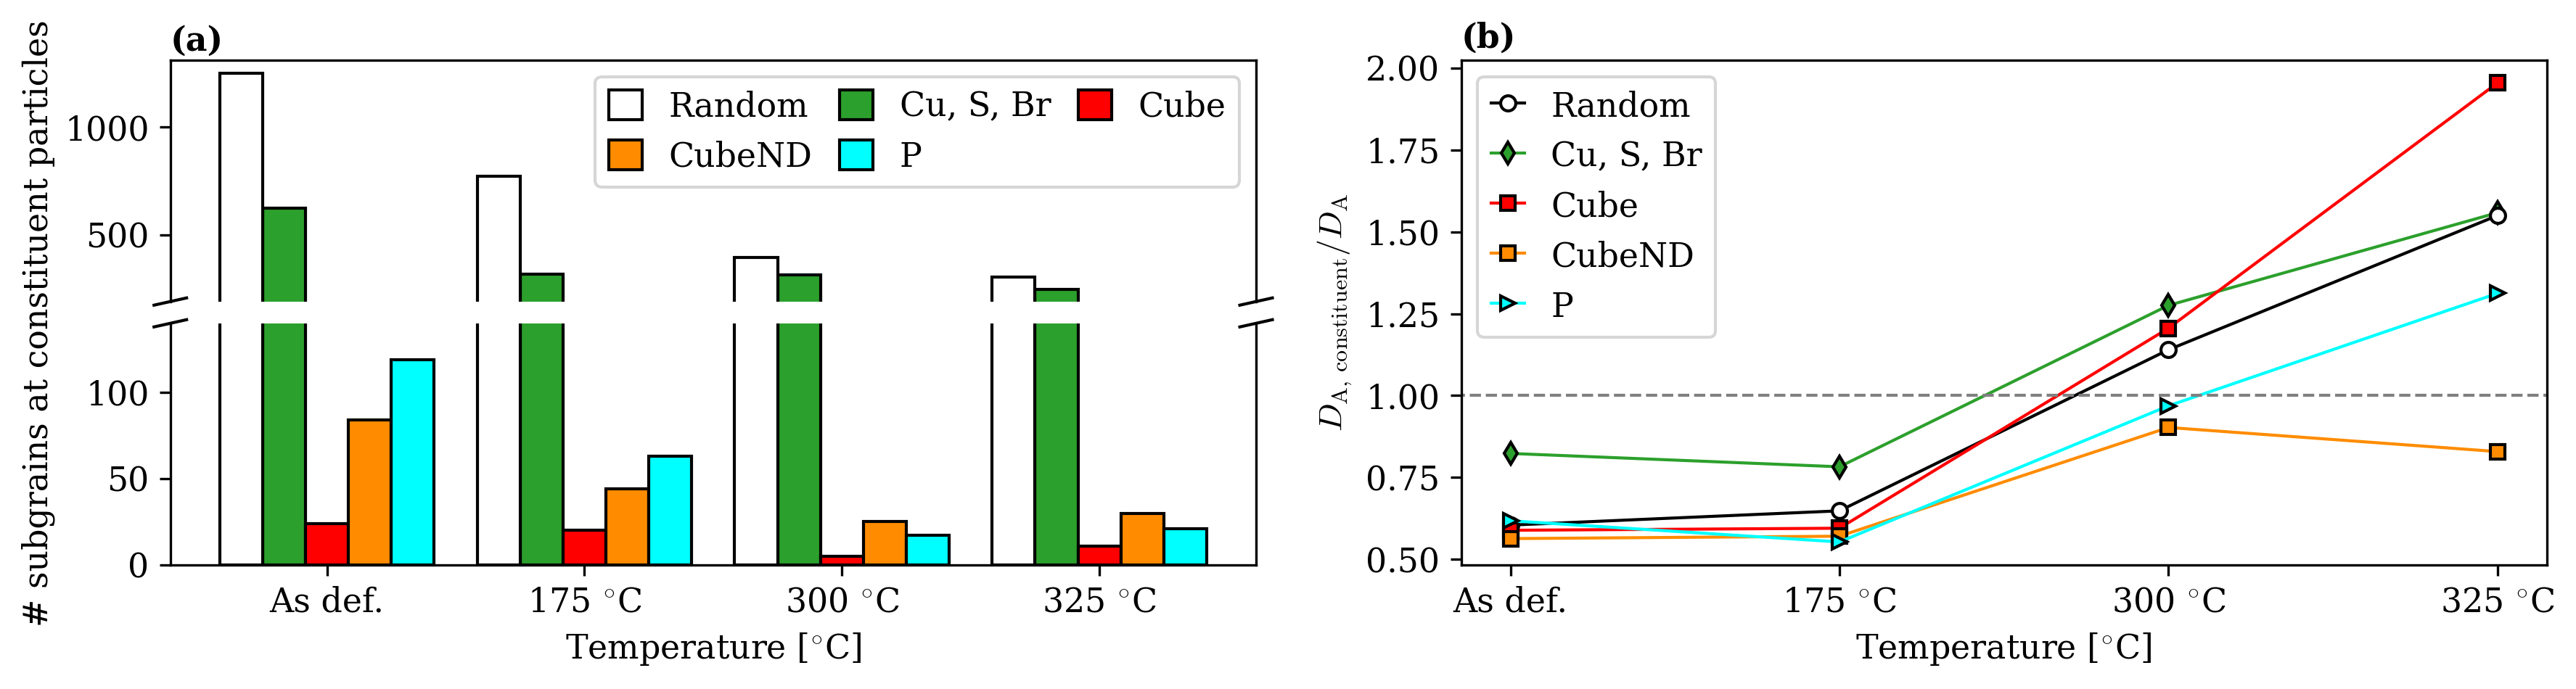

In [303]:
x = np.arange(len(grain_stats))
bar_width = 1 / 6
bar_kw = dict(width=bar_width, ec="k")

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 3.3))

# --- (a) Subgrains at constituent particles
ax0.bar(
    x - bar_width,
    grains_at_constituent.n_br + grains_at_constituent.n_cu + grains_at_constituent.n_s,
    label=comp_names[-1],
    color=comp_colors[comp_names[-1]],
    **bar_kw
)
divider = make_axes_locatable(ax0)
ax01 = divider.new_vertical(size="100%", pad=0.1)
fig.add_axes(ax01)
ax01.bar(
    x - bar_width,
    grains_at_constituent.n_br + grains_at_constituent.n_cu + grains_at_constituent.n_s,
    label=comp_names[-1],
    color=comp_colors[comp_names[-1]],
    **bar_kw
)
# Remaining grains
for w, name in zip(
    [-2 * bar_width, 0, bar_width, 2 * bar_width],
    [comp_names[0],] + comp_names[4:7],
):
    c = comp_colors[name]
    ax0.bar(x + w, grains_at_constituent[f"n_{name.lower()}"], label=name, color=c, **bar_kw)
    ax01.bar(x + w, grains_at_constituent[f"n_{name.lower()}"], label=name, color=c, **bar_kw)
# Broken axis
ax01.tick_params(bottom=False, labelbottom=False)
ax0.spines["top"].set_visible(False)
ax01.spines["bottom"].set_visible(False)
ax0.set_ylim(0, 140)
ax01.set_ylim(190)
d = 0.015
kwargs = dict(transform=ax01.transAxes, color='k', clip_on=False)
ax01.plot((-d, d), (-d, d), **kwargs)
ax01.plot((1 - d, 1 + d), (-d, d), **kwargs)
kwargs.update(transform=ax0.transAxes)
ax0.plot((-d, d), (1 - d, 1 + d), **kwargs)
ax0.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)
# Axes labels
ax0.set_xticks(x)
ax0.set_xticklabels(titles)
ax0.set_xlabel("Temperature [$^{\circ}$C]")
ax0.set_ylabel("# subgrains at constituent particles", y=1, labelpad=10);
# Legend (reorder)
ax01.legend()
handles, labels = ax01.get_legend_handles_labels()
order = [1, 3, 0, 4, 2]
ax01.legend(
    [handles[idx] for idx in order],
    [labels[idx] for idx in order],
    ncol=3,
    loc="upper right",
    columnspacing=0.83,
    handleheight=1,
    handlelength=1,
)

# --- (b) Ratio of grain sizes of subgrains at constituent particles over grain
# sizes elsewhere
ax1.plot(
    x,
    np.mean(
        [
            grains_at_constituent.ecd_area_br,
            grains_at_constituent.ecd_area_cu,
            grains_at_constituent.ecd_area_s
        ],
        axis=0,
    ),
    label=comp_names[-1],
    color=comp_colors[comp_names[-1]],
    marker=comp_markers[comp_names[-1]],
    markerfacecolor=comp_colors[comp_names[-1]],
    markeredgecolor="k",
)
for name in [comp_names[0],] + comp_names[4:7]:
    if name == "Random":
        line_color = "k"
    else:
        line_color = comp_colors[name]
    ax1.plot(
        x,
        grains_at_constituent[f"ecd_area_{name.lower()}"],
        label=name,
        marker=comp_markers[name],
        color=line_color,
        markerfacecolor=comp_colors[name],
        markeredgecolor="k",
    )
x_lims = ax1.get_xlim()
ax1.plot([x.min() - 1, x.max() + 1], [1, 1], "--", c="gray")
ax1.set_xlim(x_lims)
# Axes labels and ticks
ax1.set_xticks(x)
ax1.set_xticklabels(titles)
ax1.set_xlabel("Temperature [$^{\circ}$C]")
ax1.set_ylabel(r"$D_{\mathrm{A,\:constituent}} / D_{\mathrm{A}}$")

# Legend (reorder)
ax1.legend()
handles, labels = ax1.get_legend_handles_labels()
order = [1, 0, 2, 3, 4]
ax1.legend(
    [handles[idx] for idx in order],
    [labels[idx] for idx in order],
    loc="upper left",
    handleheight=1,
    handlelength=1,
)

# Figure labels
ax01.text(0, 1.01, "(a)", transform=ax01.transAxes, **title_kw)
ax1.text(0, 1.01, "(b)", transform=ax1.transAxes, **title_kw)

fig.tight_layout(w_pad=2)
fig.savefig(os.path.join(dir_article, "subgrains_at_constituent/n_grains_grain_size.pdf"), **savefig_kw)

In [304]:
grains_at_constituent[["ecd_area_p", "ecd_area_cubend", "ecd_area_cube"]]

,ecd_area_p,ecd_area_cubend,ecd_area_cube
0s,0.617791,0.563398,0.588801
175c,0.553142,0.570710,0.595090
300c,0.968772,0.902715,1.205859
325c,1.312296,0.829138,1.954983
